# Dataset preparation

In [1]:
import pandas as pd
data = pd.read_csv("all_data.csv",dtype={46: str, 47: str, 57: str, 58: str})

## Vytvorenie targetu
- 0=hmotná škoda
- 1=lahko zranené osoby
- 2=ťažko zranené osoby
- 3=smrť osob

In [2]:
def create_target(data):
    if data['p9'] == 2:
        return 0
    elif data['p13a'] > 0:
        return 3
    elif data['p13b'] > 0 and data['p13a'] == 0:
        return 2
    elif data['p13c'] > 0 and data['p13a'] == 0 and data['p13b'] == 0:
        return 1
    else:
        return 0  # Ak neplatí žiadna podmienka, nastavíme None

# Vytvorenie novej premennej 'target' pomocou funkcie create_target()
data['target'] = data.apply(create_target, axis=1)

In [3]:
data['target'].value_counts()

0    565457
1    125574
2     12747
3      3249
Name: target, dtype: int64

## Statistika Nehodovosti vozidel v České republice

  - Dataset přesdtavuje seznam záznamů o nehodách na území české republiky od roku 2007 do roku 2023
  - k dispozici na https://www.policie.cz/clanek/statistika-nehodovosti-900835.aspx?q=Y2hudW09Mg%3d%3d)  
  - Původně měldatase 65 sloupců, nicméně do analýzy bylo vzhledem k business zámeru vybráno jen 51 sloupců 
  
  <img src='dopravni_nehoda.jpg' width=400px/>








## Business case  

- V datasetu budeme hledat vztah mezi dílčími proměnými (typ silnice, stav vozovky, stáří auta appod) a výsledkem nehody (cílová proměná)
- Cílem je odhadlit, zda existuje jedna nebo více vysvětlujících proměnných, které by dokázali odhadnout, zda při nehodě došlo k újmě na zdraví, nebo pouze k materiální škodě na vozdile
- Odhalení tohoto vztahu společně s vytvořením funkčního modelu, který vztahy uměl v reálném čase vyodnocevat bychom mohli poskytnout složkám IZS (Integrovaný Záchraný Systém) nástroj pro adekvátní reakce při nahlášení dopravní nehody.
 - Pokud by byl oeprátor pohotovostní linky schopen z dat zaslaných havarovaným vozidlem posoudit, zda došlo k nehodě, při níž byl zraněn člověk, umožnilo by to IFZ uzpůsobit reakci závažnosti případu (např. při vážné nehodě s šancí na přežití vyslat vrtulník, který je považován za nejnákladnější typ zásahu)


## Proměnné

- Cílovou proměnnou(target) je spojení následujících dvou proměnných: 
  -  Charakter nehody (p9) má dva výsledky: 1)s následky na životě a 2)pouze s hmotnou škdou
   - Následky nehody (p13) má tři výsledky: 1)usmrceno osob 2 )Težce zraněno osob 3) lehce zraněno osob  
   - Výsledkem je 1 ordinální cílová proměnná

Vysvětlující jsou všechny ostatní proměnné - kromě 14ti ostraněných 

## Feature Engineering

In [4]:
# Vytvorenie dvoch nových premenných 'sucho' a 'mokro' na základe hodnôt 'p16'
sucho_mokro = {
    1 : 'Sucho',
    2 : 'Sucho',
    3 : 'Mokro',
    4 : 'Mokro',
    5 : 'Mokro',
    6 : 'Mokro',
    7 : 'Mokro',
    8 : 'Mokro',
    9 : 'Mokro',
    0 : 'Jiný'
}


data['Sucho_Mokro'] = data['p16'].map(sucho_mokro)
#data['Sucho'] = data['p16'].apply(lambda x: 1 if x in [1, 2] else 0)
#data['Mokro'] = data['p16'].apply(lambda x: 1 if x in [3, 5, 6, 8] else 0)

In [5]:
# Vytvorenie premennej 'rizeni' na základe hodnôt 'p23' a 'p24'
# 0 = bez rizeni
# 1 = rizeni značkami
# 2 = rizeni svetelnou signalizaciou
# 4 = rizeni policiou
def create_rizeni(row):
    if row['p23'] == 1:
        return 4
    elif row['p23'] == 2:
        return 3
    elif row['p23'] == 3 and row['p24'] in [3, 4]:
        return 2
    elif row['p23'] == 0:
        return 0
    elif row['p23'] == 3 and row['p24'] in [1, 2, 5, 0]:
        return 0
    else:
        return None  # Ak neplatí žiadna podmienka, nastavíme None

# Vytvorenie novej premennej 'rizeni' pomocou funkcie create_rizeni()
data['Rizeni'] = data.apply(create_rizeni, axis=1)
data['Rizeni'].value_counts()

0    569323
2    118654
3     16509
4      2541
Name: Rizeni, dtype: int64

In [6]:
# Vytvorenie premennej "obdobie" na základe hodnôt v premennej Datum
def create_obdobie(row):
    month = int(row['p2a'].split('-')[1])
    if month in [3, 4, 5]:
        return 'jaro'
    elif month in [6, 7, 8]:
        return 'leto'
    elif month in [9, 10, 11]:
        return 'podzim'
    else:
        return 'zima'

# Vytvorenie premennej "obdobie" pomocou funkcie create_obdobie()
data['Obdobi'] = data.apply(create_obdobie, axis=1)
data['Obdobi'].value_counts()

podzim    188265
leto      186515
jaro      169814
zima      162433
Name: Obdobi, dtype: int64

In [7]:
# Vytvorenie premennej "vikend" na základe hodnôt v premennej Datum
def create_vikend(row):
    date = pd.to_datetime(row['p2a'])
    if date.weekday() <= 5:
        return 0
    else:
        return 1

# Vytvorenie premennej "vikend" pomocou funkcie create_vikend()
data['Vikend'] = data.apply(create_vikend, axis=1)
data['Vikend'].value_counts()

0    633584
1     73443
Name: Vikend, dtype: int64

In [8]:
#Vytvorenie premennej "obec", ktorá je 1, ak je nehoda v obci
data['Obec'] = data['p5a'].apply(lambda x: 1 if x == 1 else 0)

In [9]:
# Vytvorenie premennej "Prekrocena_rychlost" na základe hodnôt v premennej "p12"
data['Prekrocena_rychlost'] = data['p12'].apply(lambda x: 1 if 201 <= x <= 209 else 0)

In [10]:
# Vytvorenie premenné "Tech_zavada" na základe hodnôt v premennej "p12"
data['Tech_zavada'] = data['p12'].apply(lambda x: 1 if 601 <= x <= 615 else 0)

### Druh pevné překážky p(8)
0 nebyla srážka s pevnou překážkou
1 srážka s epvnou překážkou

In [11]:
# Namapování proměnné "Druhe_pevne_prekazky" ze sloupce p7
nahrada_p8 = {
    1: 'strom',
    2: 'sloup',
    3: 'odrazník, patník',
    4: 'svodidlo',
    5: 'překážka vzniklá provozem jiného vozidla',
    6: 'zeď, pevná část mostů',
    7: 'závory železničního přejezdu',
    8: 'překážka vzniklá stavební činností',
    9: 'jiná překážka',
    0: 'nepříchází v úvahu'
}

data['Srazka_s_pevnou_prekazkou'] = data['p8'].map(nahrada_p8)
display(data['Srazka_s_pevnou_prekazkou'].value_counts())
#Sloučení hodnot do true/false proměnné na základě četností
nahrada_p8 = {
    1: 1,
    2: 1,
    3: 1,
    4: 1,
    5: 1,
    6: 1,
    7: 1,
    8: 1,
    9: 1,
    0: 0
}
data['Srazka_s_pevnou_prekazkou'] = data['p8'].map(nahrada_p8)

display(data['Srazka_s_pevnou_prekazkou'].value_counts())

nepříchází v úvahu                          557841
jiná překážka                                43641
odrazník, patník                             27507
sloup                                        19879
svodidlo                                     19190
strom                                        17632
zeď, pevná část mostů                        16974
překážka vzniklá stavební činností            2416
překážka vzniklá provozem jiného vozidla      1109
závory železničního přejezdu                   838
Name: Srazka_s_pevnou_prekazkou, dtype: int64

0    557841
1    149186
Name: Srazka_s_pevnou_prekazkou, dtype: int64

### Směr srážky (p7)
1 čelní
2 boční
3 z boku
4 zezadu
0 nepřichází v úvahu

In [12]:
#Namapování pro "Smer_srazky" proměnná p7
old_rows = [1, 2, 3, 4, 0] 
new_rows = ['čelní', 'boční', 'z boku', 'zezadu', 'nepřichází v úvahu'] # Rename the rows in the 'Srazka' column
data['Smer_srazky'] = data['p7'].replace(old_rows, new_rows) # Print the updated dataframeprint(df)
data['Smer_srazky'].value_counts()

nepřichází v úvahu    476632
zezadu                 76765
boční                  67040
z boku                 64446
čelní                  22144
Name: Smer_srazky, dtype: int64

### Směr staničení (jízdy) p52

In [13]:
# Vytvorenie noveho slupca "staniceni"

def create_staniceni(data):
    if data['p52'] < 3:
        return 've smeru'
    elif data['p52'] < 5 :
        return 'proti smeru'
    elif data['p52'] < 7:
        return 'bez staniceni'
    elif data['p52'] < 100:
        return 'krizovatka'
    else:
        return data['p52']  # Ak neplatí žiadna podmienka, nastavíme původní hodnotu

# Vytvorenie novej premennej 'target' pomocou funkcie create_target()
data['Staniceni'] = data.apply(create_staniceni, axis=1)
#data['staniceni'] = ' '

#data.loc[data['p52'].isin([1, 2]), 'staniceni'] = 'v smere'
#data.loc[data['p52'].isin([3, 4]), 'staniceni'] = 'proti smeru'
#data.loc[data['p52'].isin([5, 6]), 'staniceni'] = 'bez staniceni'
#data.loc[data['p52'].between(7, 99), 'staniceni'] = 'krizovatka'
#data['staniceni'] = data["p52"].map(smer)
display(data["Staniceni"].value_counts())

bez staniceni    208465
ve smeru         203023
proti smeru      109174
krizovatka        66129
Name: Staniceni, dtype: int64

### Druh povrchu p15

In [14]:
# Namapování proměnné p15 Druh povrchu nehody
old_rows = [1, 2, 3, 4, 5, 6, 0]
new_rows = ['dlažba', 'živice', 'beton', 'panely', 'štěrk', 'jiný povrch','jiný povrch']
# Rename the rows in the 'Druh_povrchu' 
data['Druh_povrchu'] = data['p15'].replace(old_rows, new_rows)
data['Druh_povrchu'].value_counts()

živice         636394
dlažba          42218
beton           15226
štěrk            6387
jiný povrch      5399
panely           1401
Name: Druh_povrchu, dtype: int64

### Situování nehody na komunikaci (p22)

In [15]:
# Vytvoření 3 proměnných podle situování nehody - jízdní pruh, mimo komunikaci, jiné 
def situovani_nehody(row):
    typ_nehody = int(row['p22'])
    if typ_nehody == 1:
        return 'jízdní pruh'
    elif typ_nehody == 8:
        return 'mimo komunikaci'
    else:
        return 'jiné'

data['situovani_nehody'] = data.apply(situovani_nehody, axis=1)
display(data['situovani_nehody'].value_counts())

jízdní pruh        573839
jiné                87843
mimo komunikaci     45345
Name: situovani_nehody, dtype: int64

### Druh nehody (p6)

In [16]:
# Seskupení a přepsání 'p6'
data['p6'].replace({1: 'jedouci_vozidlo', 7: 'jedouci_vozidlo', 8: 'jedouci_vozidlo'}, inplace=True)
data['p6'].replace({0: 'jine', 4: 'jine'}, inplace=True)
data['p6'].replace({5: 'zver', 6: 'zver'}, inplace=True)
data['p6'].replace({9: 'havarie'}, inplace=True)
data['p6'].replace({3: 'pevna_prekazka'}, inplace=True)
data['p6'].replace({2: 'odstavene_vozidlo'}, inplace=True)
data['Druh_nehody'] = data['p6']
display(data['Druh_nehody'].value_counts())

jedouci_vozidlo      230395
odstavene_vozidlo    154906
pevna_prekazka       149186
zver                  96712
jine                  38437
havarie               37391
Name: Druh_nehody, dtype: int64

### Stav komunikace (p17)

In [17]:
#p17
new_names_mapping = {
    1: 'dobrý, bez závad',
    2: 'sklon 8%+',
    3: 'změna vozovky/překážka',
    4: 'změna vozovky/překážka',
    5: 'výtluky',
    6: 'výtluky',
    7: 'změna vozovky/překážka',
    8: 'změna vozovky/překážka',
    9: 'změna vozovky/překážka',
    10: 'změna vozovky/překážka',
    11: 'změna vozovky/překážka',
    12: 'jiný stav'
}
data['Stav_komunikace'] = data['p17'].map(new_names_mapping)
display(data['Stav_komunikace'].value_counts())

dobrý, bez závad          686767
jiný stav                   9938
výtluky                     4857
změna vozovky/překážka      3818
sklon 8%+                   1645
Name: Stav_komunikace, dtype: int64

### Videtelnost (p19)

In [18]:
#popis p19 - Viditelnost
#1 - viditelnost nezhoršená vlivem povětrnostních podmínek
#2 - zhoršená viditelnost (svítání, soumrak)
#3 - zhoršená viditelnost vlivem povětrnostních podmínek (mlha, sněžení, déšť apod.)
#4 - s veřejným osvětlením, viditelnost nezhoršená vlivem povětrnostních podmínek
#5 - s veřejným osvětlením, zhoršená viditelnost vlivem povětrnostních podmínek (mlha, déšť, sněžení apod.)
#6 - bez veřejného osvětlení, viditelnost nezhoršená vlivem povětrnostních podmínek
#7 - bez veřejného osvětlení, viditelnost zhoršená vlivem povětrnostních podmínek (mlha, déšť, sněžení apod.)

data['Viditelnost'] = data['p19']
print(data['Viditelnost'].value_counts())

1.0    470361
4.0     81592
6.0     77762
2.0     36863
3.0     24098
7.0      9025
5.0      7324
Name: Viditelnost, dtype: int64


### Místa a objekty (p27)

In [19]:
new_names_mapping = { 
    1: 'Přechod pro chodce', 
    2: 'Přechod pro chodce', 
    3: 'Přejezd/most', 
    4: 'Přejezd/most', 
    5: 'Přejezd/most', 
    6: 'Zastávka/čerpadlo', 
    7: 'Zastávka/čerpadlo', 
    8: 'Parkoviště', 
    9: 'Zastávka/čerpadlo', 
    10: 'Parkoviště', 
    0: 'žádné nebo žádné z uvedených' } 
# Rename the rows in 'objekty' column based on the new names mapping 
data['Objekty'] = data['p27'].map(new_names_mapping)
display(data['Objekty'].value_counts())

žádné nebo žádné z uvedených    557949
Parkoviště                       70879
Přechod pro chodce               54817
Zastávka/čerpadlo                12722
Přejezd/most                     10660
Name: Objekty, dtype: int64

### Dělení komunikace (p21)

In [20]:
#popis p21 - Delenie komunikacie

#1 - dvoupruhová
#2 - třípruhová
#3 - čtyřpruhová s dělícím pásem
#4 -čtyřpruhová s dělící čarou
#5 - vícepruhová
#6- rychlostní komunikace
#0 - žádné z uvedených

data['Deleni_komunikace'] = data['p21']
data['p21'].value_counts()

1    509855
0     90607
2     39219
3     38788
5     15478
4      9403
6      3677
Name: p21, dtype: int64

### Povětrnostní podmínky p(18)


In [21]:
data = data.dropna(subset=['p18'])

# p18 Povětrnostní podmínky v době nehody
def povetrnostni_podminky(row):
    podminky = int(row['p18'])
    if podminky == 1:
        return 'neztizene'
    elif podminky == 3:
        return 'slaby dest'
    elif podminky == 4:
        return 'silny dest'
    elif podminky == 2:
        return 'mlha'
    elif podminky == 6 or podminky == 5:
        return 'snih'
    else:
        return 'jine'
data['povetrnostni_podminky'] = data.apply(povetrnostni_podminky, axis=1)
data['povetrnostni_podminky'].value_counts()

neztizene     621583
silny dest     30406
slaby dest     24794
snih           21351
mlha            6240
jine            2651
Name: povetrnostni_podminky, dtype: int64

### Druh komunikace (p36)


In [22]:
new_names_mapping = { 
    0: 'dálnice', 
    1: 'komunikace s třídou', 
    2: 'komunikace s třídou', 
    3: 'komunikace s třídou', 
    4: 'místní komunikace', 
    5: 'místní komunikace', 
    6: 'místní komunikace', 
    7: 'místní komunikace', 
    8: 'místní komunikace', 
}

# Rename the rows in 'druh komunikace' column based on the new names mapping 
data['Druh_komunikace'] = data['p36'].map(new_names_mapping)
display(data['Druh_komunikace'].value_counts())

místní komunikace      377917
komunikace s třídou    298921
dálnice                 30187
Name: Druh_komunikace, dtype: int64

### Směrové poměry (p28)

In [23]:
# p28 směrové poměry
def smerove_pomery(row):
    podminky = int(row['p28'])
    if podminky == 1 or podminky == 2:
        return 'primy'
    elif podminky == 3:
        return 'zatacka'
    elif podminky == 4 or podminky == 5 or podminky == 6:
        return 'krizovatka'
    elif podminky == 7:
        return 'kruhový objezd'

data['Smerove_pomery'] = data.apply(smerove_pomery, axis=1)
data['Smerove_pomery'].value_counts()

primy             505121
krizovatka        113640
zatacka            80576
kruhový objezd      7688
Name: Smerove_pomery, dtype: int64

### Druh vozidla (p44)

In [24]:
#Ponechání pouze osobních a nákladních aut, které mohou mít eCall
# Vytvoření seznamu hodnot, které chcete ponechat
keep_values = [3, 4, 5, 6, 7]
# Výběr řádků, které obsahují hodnoty z seznamu v proměnné 'p44'
data = data.loc[data['p44'].isin(keep_values)]
#Přejmenování hodnot
new_names_mapping = {
    3: 'osobní bez přívěsu',
    4: 'osobní s přívěsem',
    5: 'náskladní bez přívěsu',
    6: 'náskladní s přívěsem',
    7: 'nákladní s návěsem'
}
data['Druh_vozidla'] = data['p44'].map(new_names_mapping)

In [25]:
# Ostranění sloupců
df = data 
df['Smyk'] = df['p49']
columns_to_drop = ['p5a','p6','p7','p8','p10','p9', 'p11','p12', 'p13a','p13b','p13c','p14','p15','p16','p17','p18','p19','p20','p21', 'p22' ,'p24','p23','p27','p28', 'p35','p36' ,'p39','p44','p48a', 'p49','p50a', 'p50b', 'p52','p51','p52', 'p53', 'p55a', 'p57', 'p58','a','b',
                  'd','e','f','g','h','i','j','l','n','o','p','q','r','s','t','k','weekday(p2a)','Unnamed: 0']
df = df.drop(columns_to_drop, axis=1)
# Přejmenování sloupců

df = df.rename(columns={'p1': 'ID', 'p2a': 'Datum',
                        'p2b': 'Cas', 'p12': 'Pricina',
                        'p34': 'Pocet_vozidel', 'p37': 'Cislo_komunikace',
                        'p45a': 'Znacka', 'p47': 'Rok_vyroby'
                       })

df = df.drop(['Cislo_komunikace','Znacka','Rok_vyroby','Cas'], axis=1)
pd.set_option('display.max_columns', None)
#df = df.astype(str)
df.head(5)
df = df.set_index('ID')

## EDA

In [26]:
# Získanie počtu chýbajúcich hodnôt pre každú premennú
missing_values = df.isnull().sum()

# Zobrazenie názvov premenných a počtu chýbajúcich hodnôt
for column, count in missing_values.items():
    print(f'{column}: {count}')

Datum: 0
Pocet_vozidel: 0
region: 0
target: 0
Sucho_Mokro: 0
Rizeni: 0
Obdobi: 0
Vikend: 0
Obec: 0
Prekrocena_rychlost: 0
Tech_zavada: 0
Srazka_s_pevnou_prekazkou: 0
Smer_srazky: 0
Staniceni: 0
Druh_povrchu: 0
situovani_nehody: 0
Druh_nehody: 0
Stav_komunikace: 0
Viditelnost: 0
Objekty: 0
Deleni_komunikace: 0
povetrnostni_podminky: 0
Druh_komunikace: 0
Smerove_pomery: 0
Druh_vozidla: 0
Smyk: 3


In [27]:
# nahrazení chybějicích hodnot nulou
df = df.fillna(0)
missing_values = df.isnull().sum()
for column, count in missing_values.items():
    print(f'{column}: {count}')

Datum: 0
Pocet_vozidel: 0
region: 0
target: 0
Sucho_Mokro: 0
Rizeni: 0
Obdobi: 0
Vikend: 0
Obec: 0
Prekrocena_rychlost: 0
Tech_zavada: 0
Srazka_s_pevnou_prekazkou: 0
Smer_srazky: 0
Staniceni: 0
Druh_povrchu: 0
situovani_nehody: 0
Druh_nehody: 0
Stav_komunikace: 0
Viditelnost: 0
Objekty: 0
Deleni_komunikace: 0
povetrnostni_podminky: 0
Druh_komunikace: 0
Smerove_pomery: 0
Druh_vozidla: 0
Smyk: 0


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 531838 entries, 190206200001 to 61306160599
Data columns (total 26 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Datum                      531838 non-null  object 
 1   Pocet_vozidel              531838 non-null  int64  
 2   region                     531838 non-null  object 
 3   target                     531838 non-null  int64  
 4   Sucho_Mokro                531838 non-null  object 
 5   Rizeni                     531838 non-null  int64  
 6   Obdobi                     531838 non-null  object 
 7   Vikend                     531838 non-null  int64  
 8   Obec                       531838 non-null  int64  
 9   Prekrocena_rychlost        531838 non-null  int64  
 10  Tech_zavada                531838 non-null  int64  
 11  Srazka_s_pevnou_prekazkou  531838 non-null  int64  
 12  Smer_srazky                531838 non-null  object 
 13  Staniceni    

In [29]:
df.head()

,Datum,Pocet_vozidel,region,target,Sucho_Mokro,Rizeni,Obdobi,Vikend,Obec,Prekrocena_rychlost,Tech_zavada,Srazka_s_pevnou_prekazkou,Smer_srazky,Staniceni,Druh_povrchu,situovani_nehody,Druh_nehody,Stav_komunikace,Viditelnost,Objekty,Deleni_komunikace,povetrnostni_podminky,Druh_komunikace,Smerove_pomery,Druh_vozidla,Smyk
ID,,,,,,,,,,,,,,,,,,,,,,,,,,
190206200001,2020-01-01,1,Karlovarsky,0,Sucho,0,zima,0,0,0,0,0,nepřichází v úvahu,proti smeru,živice,jízdní pruh,havarie,"dobrý, bez závad",1.0,žádné nebo žádné z uvedených,2,neztizene,komunikace s třídou,zatacka,osobní bez přívěsu,0.0
190206200002,2020-01-01,1,Karlovarsky,0,Mokro,2,zima,0,0,1,0,1,nepřichází v úvahu,krizovatka,živice,jízdní pruh,pevna_prekazka,"dobrý, bez závad",1.0,žádné nebo žádné z uvedených,2,snih,komunikace s třídou,krizovatka,osobní bez přívěsu,1.0
190206200003,2020-01-01,2,Karlovarsky,0,Mokro,0,zima,0,0,0,0,0,čelní,proti smeru,živice,jízdní pruh,jedouci_vozidlo,"dobrý, bez závad",1.0,žádné nebo žádné z uvedených,4,snih,komunikace s třídou,primy,osobní bez přívěsu,0.0
190206200004,2020-01-02,1,Karlovarsky,0,Mokro,2,zima,0,1,1,0,1,nepřichází v úvahu,krizovatka,živice,jízdní pruh,pevna_prekazka,"dobrý, bez závad",4.0,žádné nebo žádné z uvedených,1,snih,komunikace s třídou,krizovatka,osobní bez přívěsu,1.0
190206200005,2020-01-03,3,Karlovarsky,0,Mokro,2,zima,0,1,1,0,0,nepřichází v úvahu,bez staniceni,dlažba,jízdní pruh,odstavene_vozidlo,"dobrý, bez závad",5.0,žádné nebo žádné z uvedených,0,snih,místní komunikace,krizovatka,osobní bez přívěsu,1.0


## Realationships with target

In [30]:
# Podíl dílčích typů targetu (hmotná škoda/újma/smrt) na jednotlivých stavech vysvětlujících proměnných 

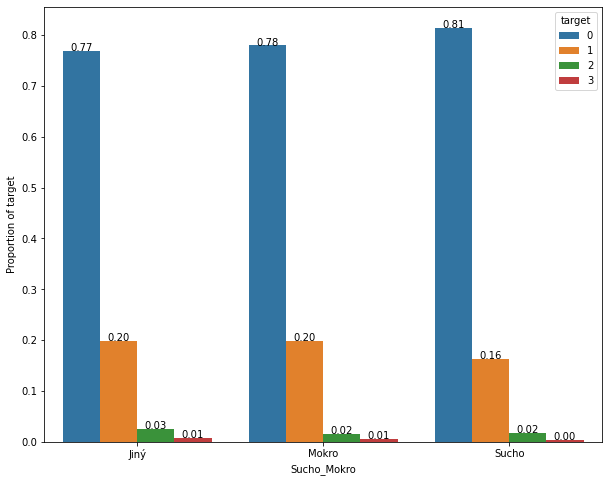

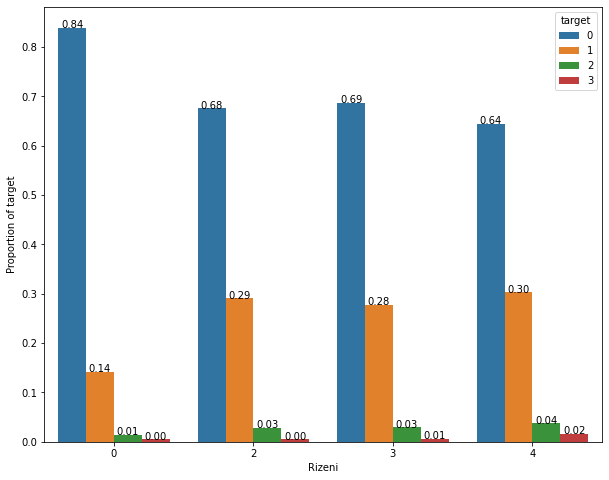

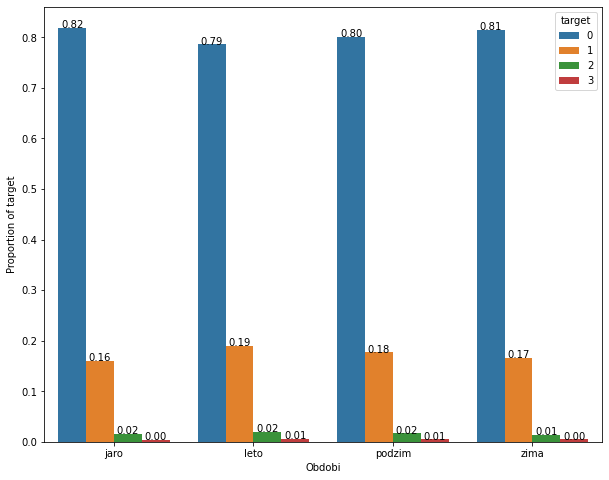

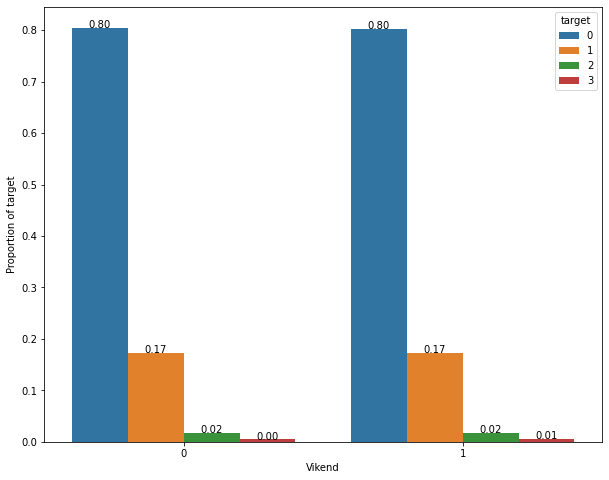

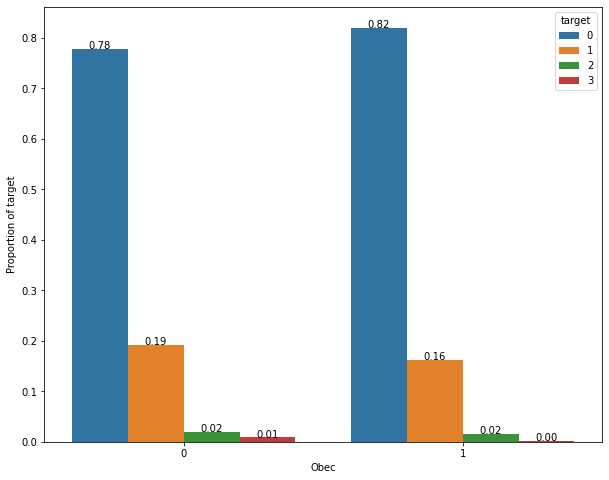

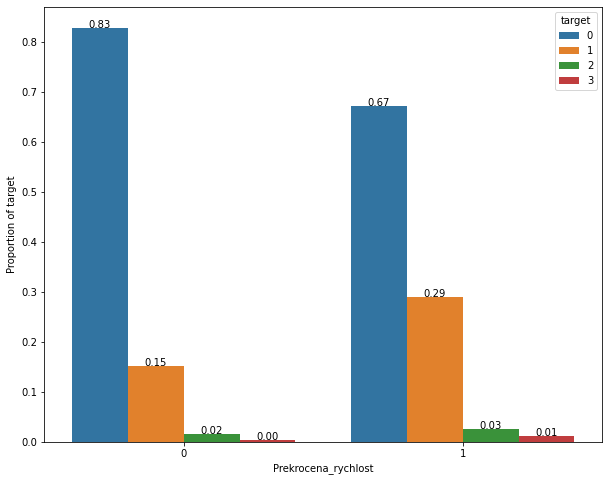

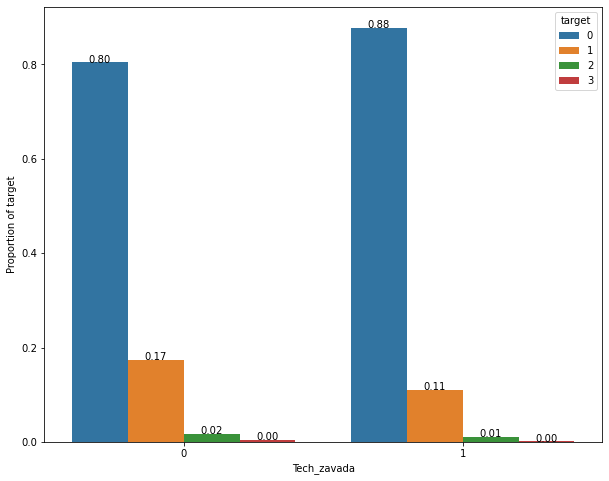

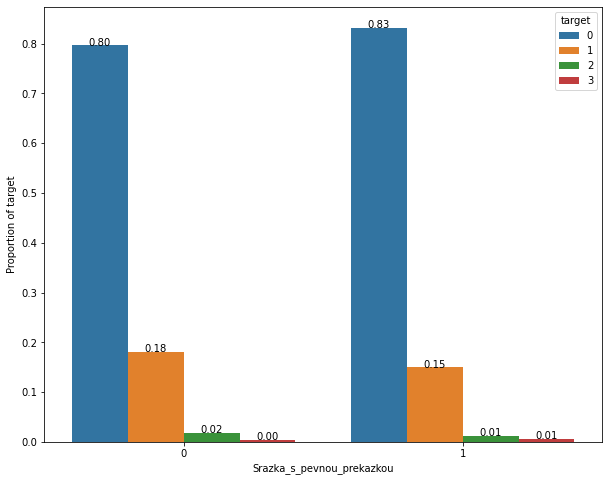

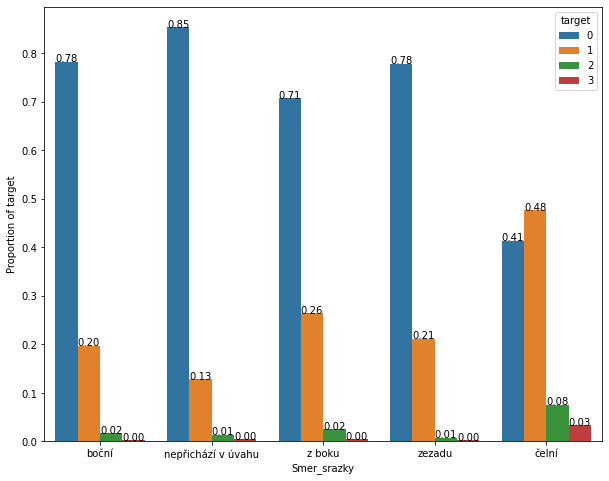

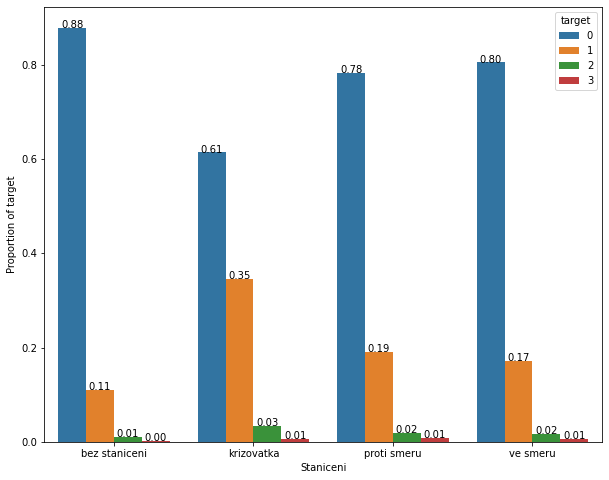

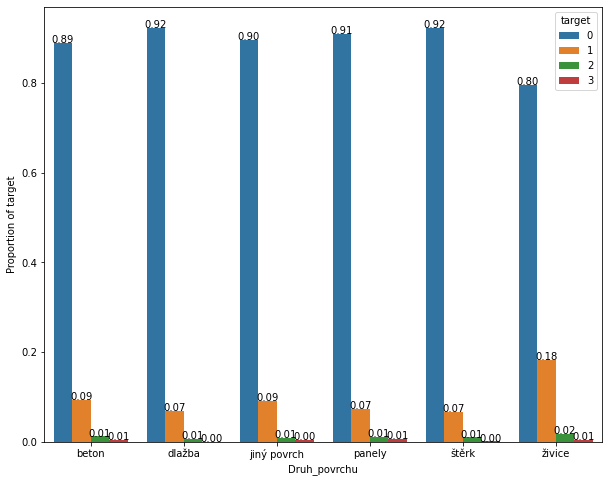

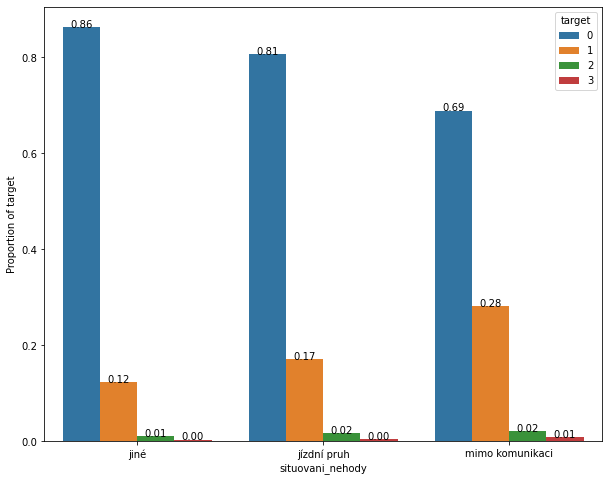

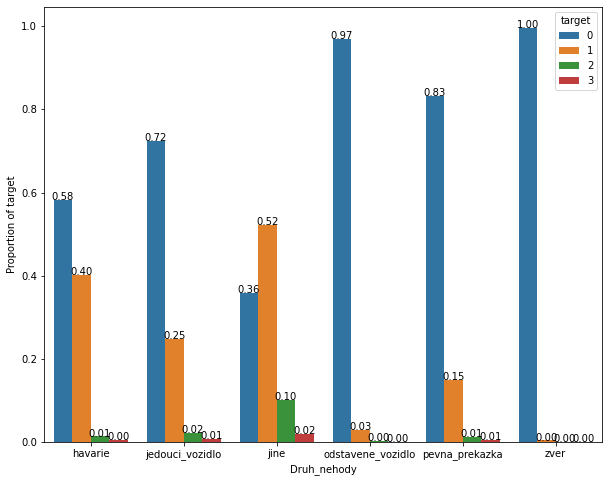

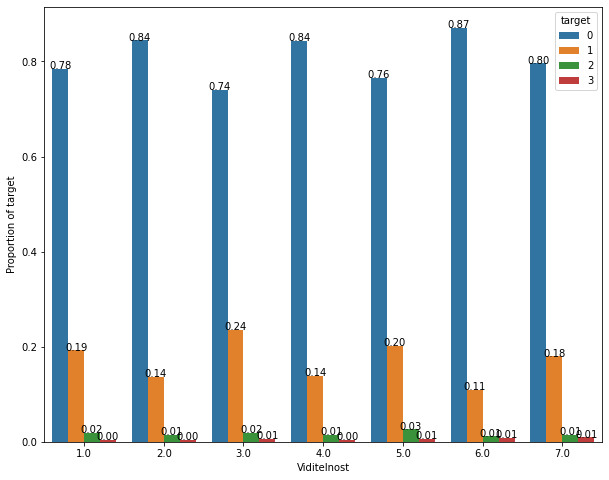

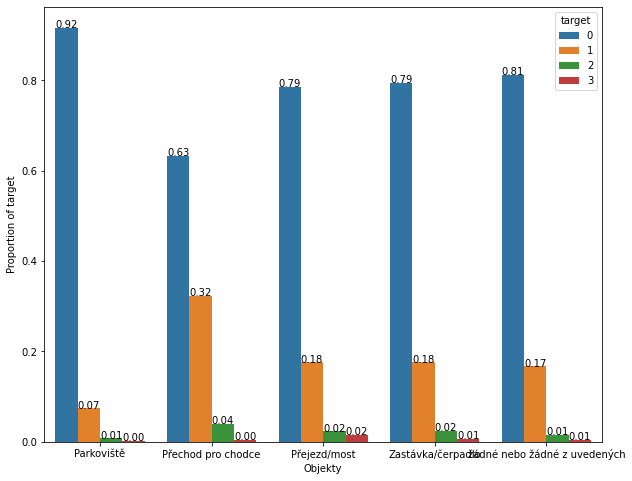

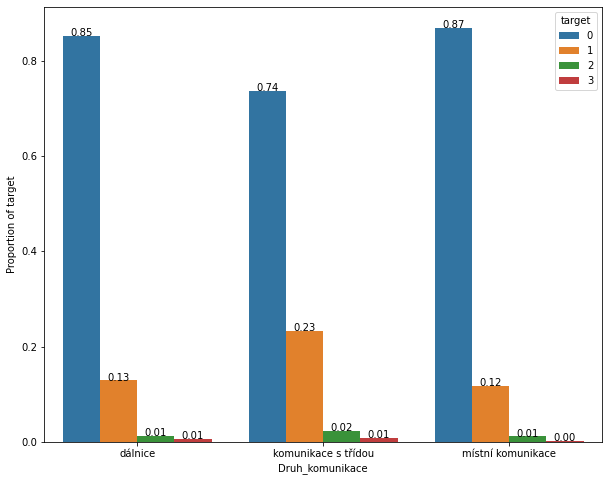

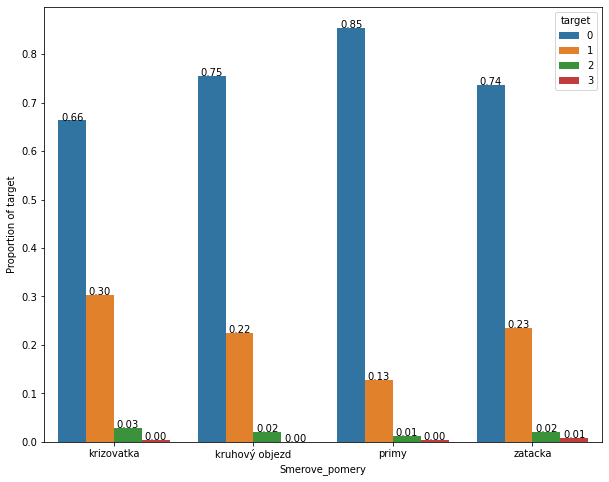

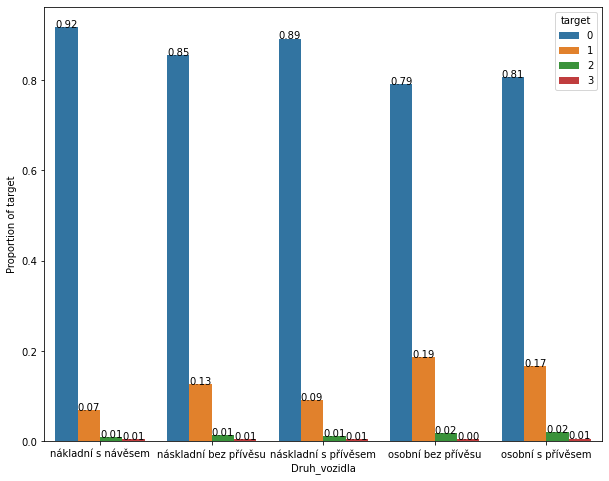

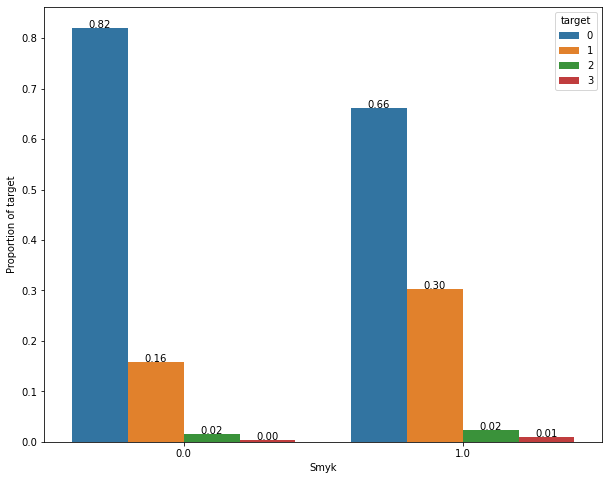

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

exclude_columns = ['Datum', 'Pocet_vozidel', 'region', 'Stav_komunikace', 'Deleni_komunikace', 'povetrnostni_podminky']

for column in df.columns:
    if column != 'target' and column not in exclude_columns: 
        counts = df.groupby(column)['target'].value_counts().reset_index(name='count')
        total_counts = df.groupby(column)['target'].count().reset_index(name='total_count')
        merged = pd.merge(counts, total_counts, on=column)
        merged['proportion'] = merged['count'] / merged['total_count']

        plt.figure(figsize=(10, 8))
        ax = sns.barplot(x=column, y='proportion', hue='target', data=merged)

        for p in ax.patches:
            height = p.get_height()
            if np.isfinite(height):  
                ax.text(p.get_x() + p.get_width() / 2., height,
                        '{:1.2f}'.format(height),
                        ha='center')

        plt.xlabel(column)
        plt.ylabel('Proportion of target')
        plt.show()



In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
"""
for col in df.columns:
    # vykreslení histogramu pro numerické proměnné
    if df[col].dtype == "int64" or df[col].dtype == "float64":
        plt.hist(df[col], bins=10)
        plt.xlabel(col)
        plt.ylabel("Počet pozorování")
        plt.title(f"Histogram {col}")
        plt.show()
      # vykreslení sloupcového grafu pro kategoriální proměnné
    else:
        sns.countplot(data=data, x=col)
        plt.xlabel(col)
        plt.ylabel("Počet pozorování")
        plt.title(f"Počet pozorování pro {col}")
        plt.show() 
"""
#sns.countplot(data=df,x='Stav_komunikace')


'\nfor col in df.columns:\n    # vykreslení histogramu pro numerické proměnné\n    if df[col].dtype == "int64" or df[col].dtype == "float64":\n        plt.hist(df[col], bins=10)\n        plt.xlabel(col)\n        plt.ylabel("Počet pozorování")\n        plt.title(f"Histogram {col}")\n        plt.show()\n      # vykreslení sloupcového grafu pro kategoriální proměnné\n    else:\n        sns.countplot(data=data, x=col)\n        plt.xlabel(col)\n        plt.ylabel("Počet pozorování")\n        plt.title(f"Počet pozorování pro {col}")\n        plt.show() \n'

<Figure size 1080x432 with 0 Axes>

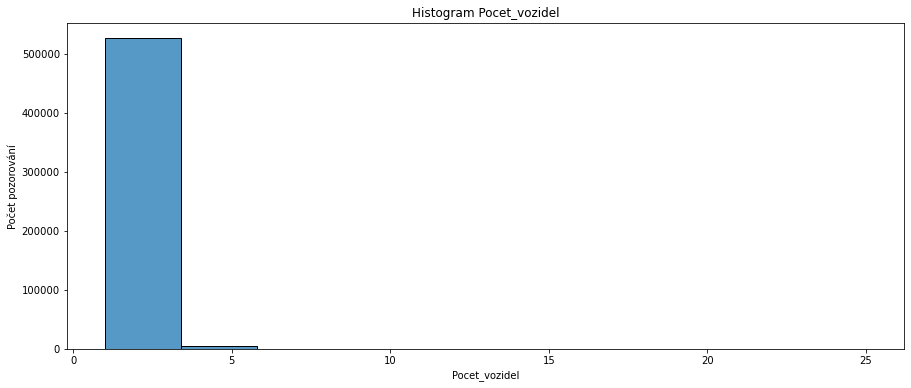

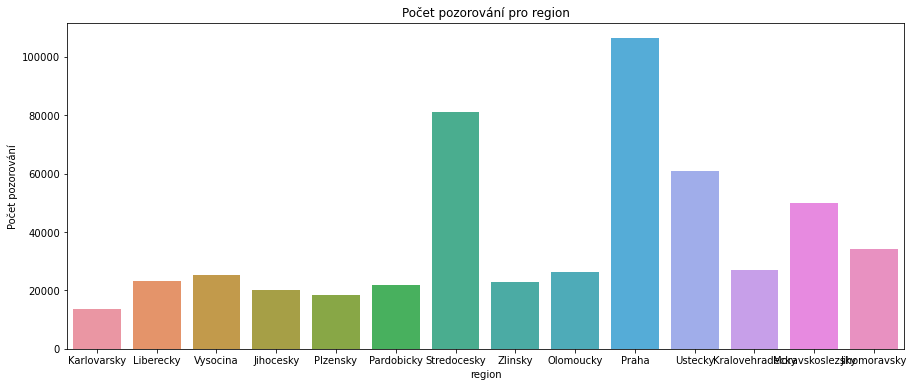

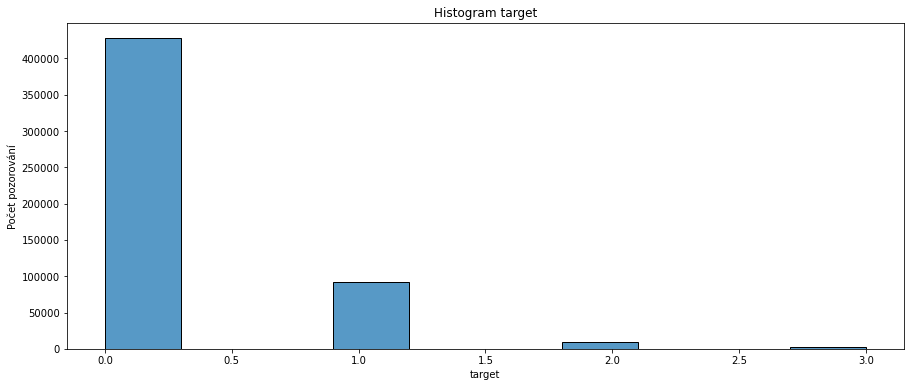

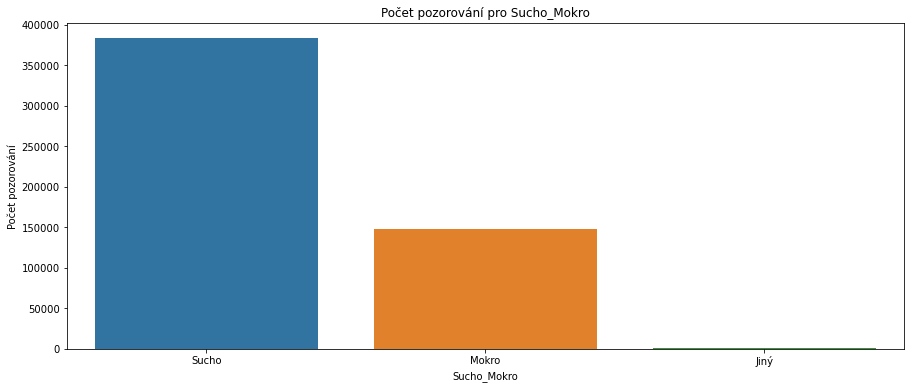

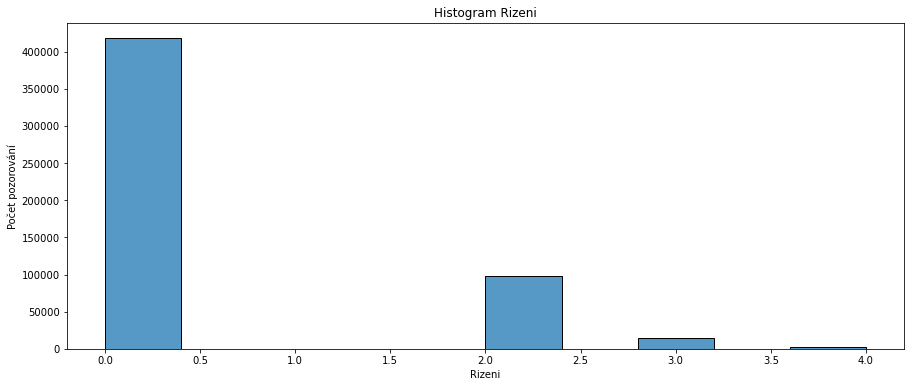

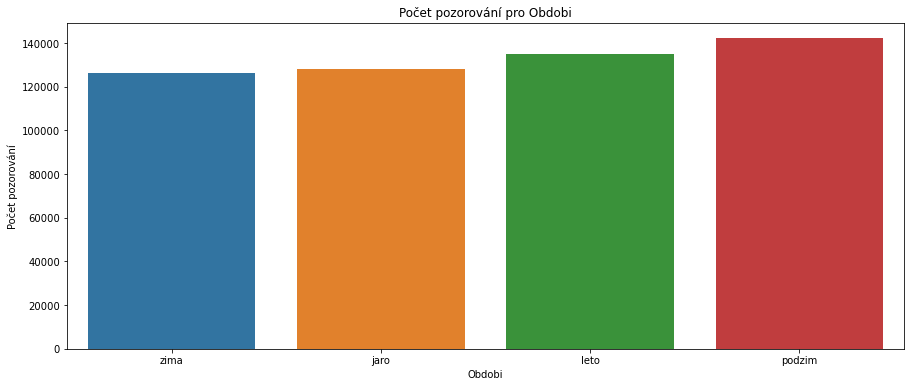

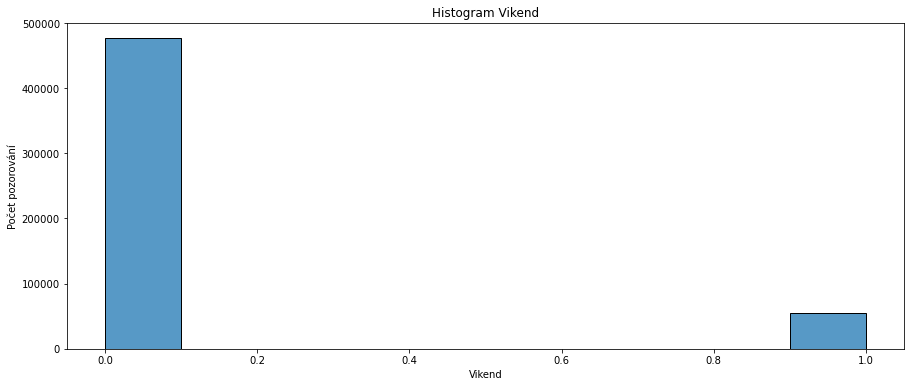

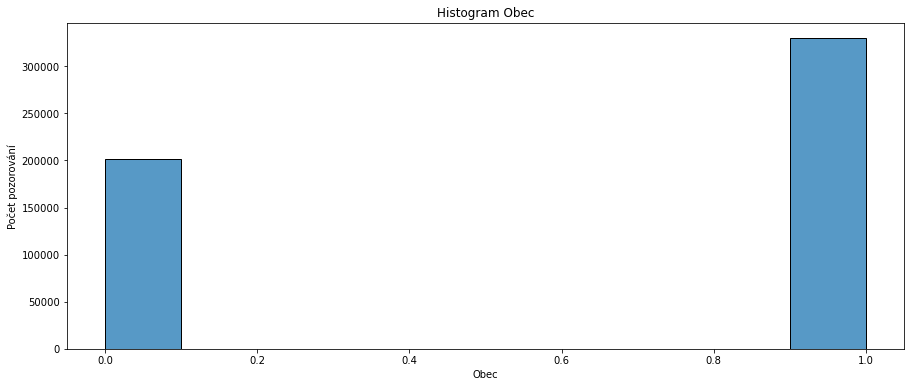

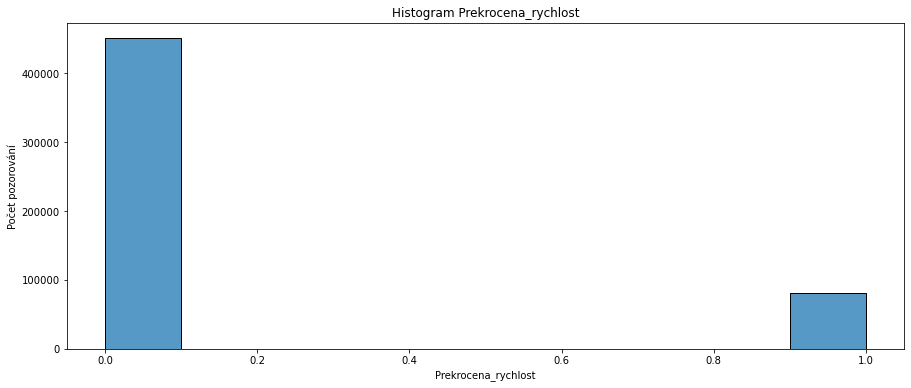

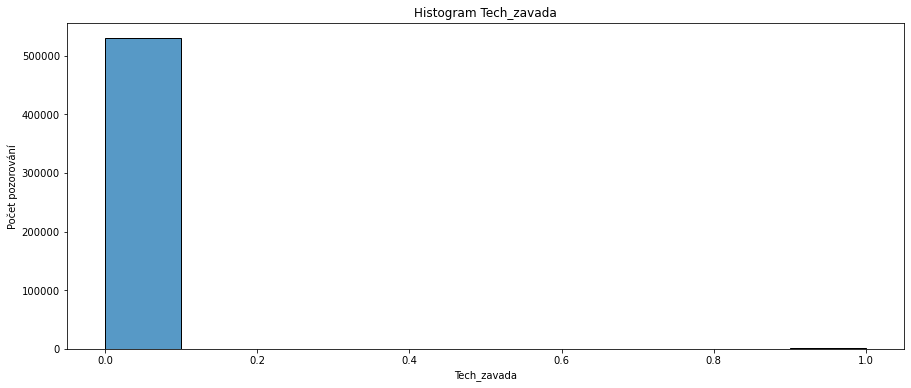

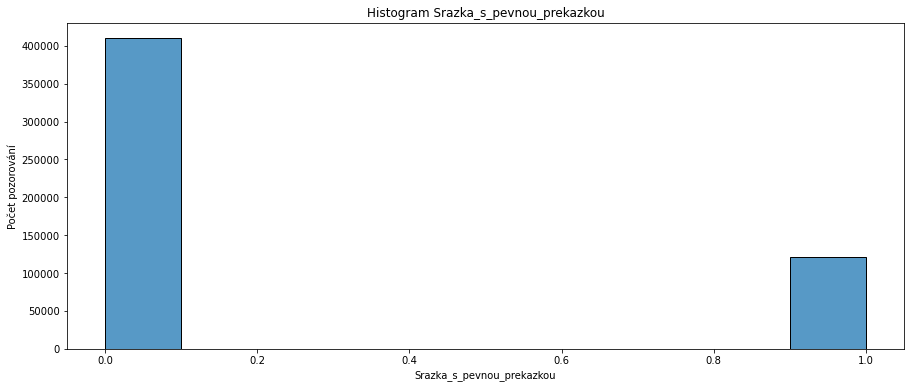

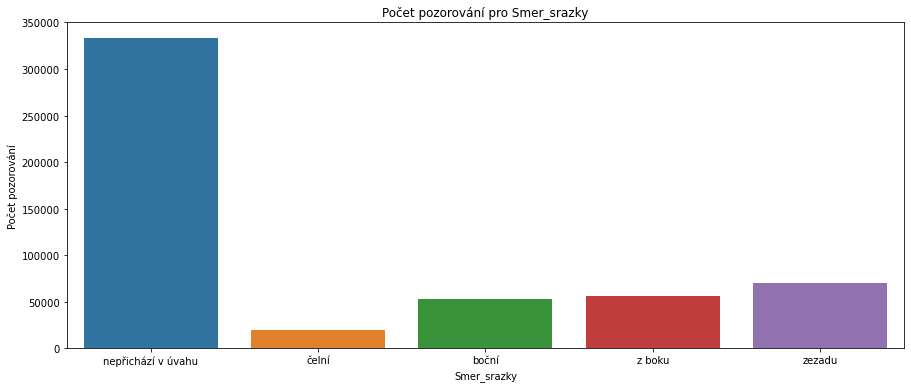

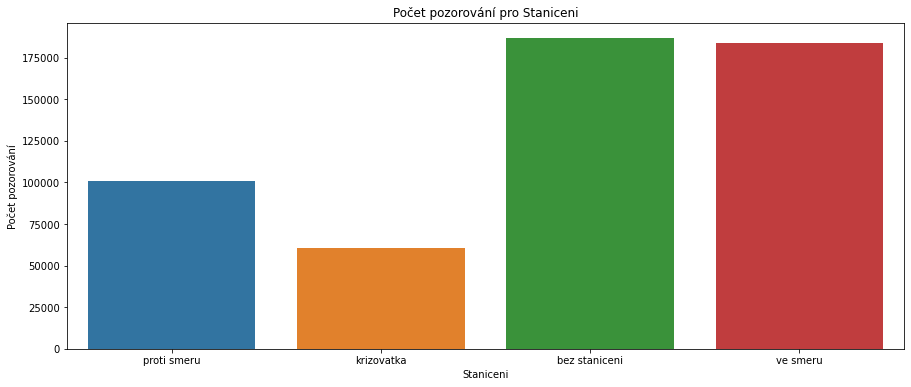

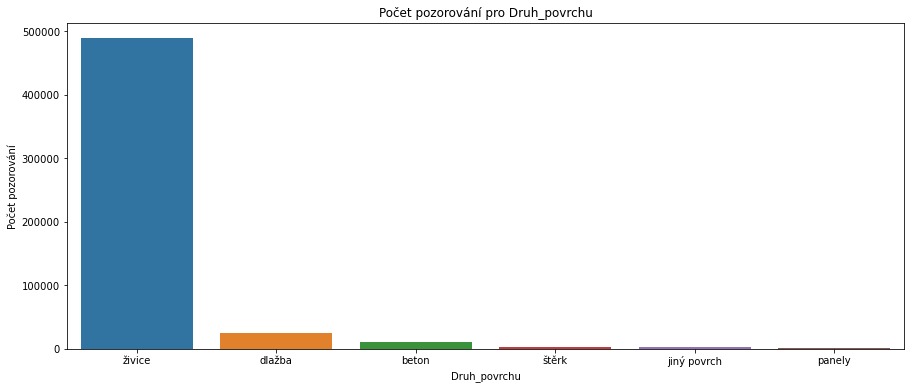

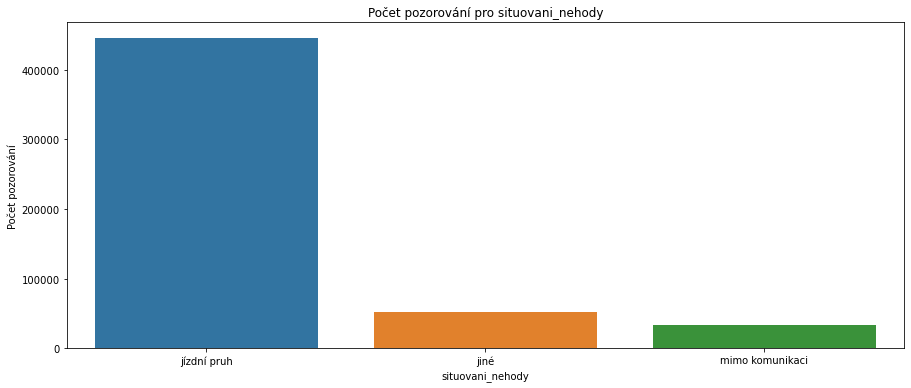

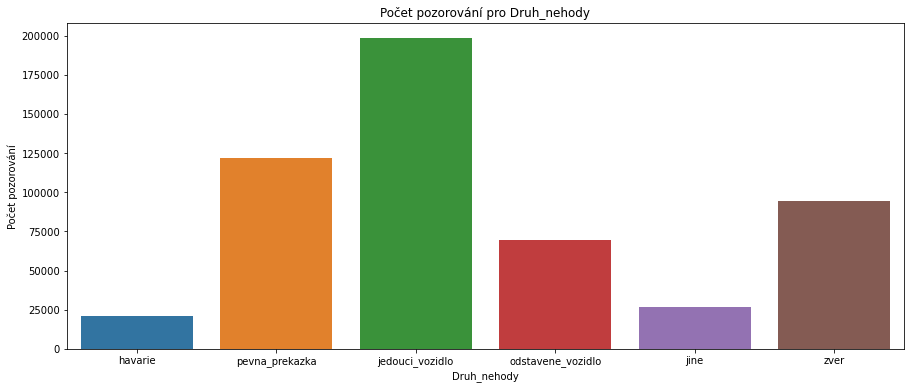

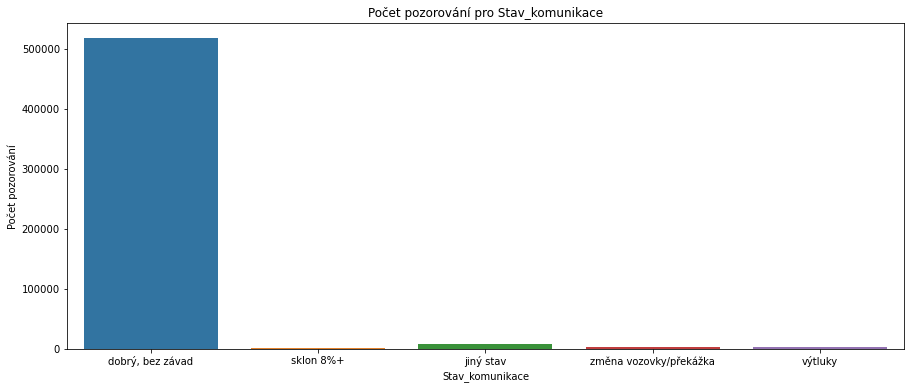

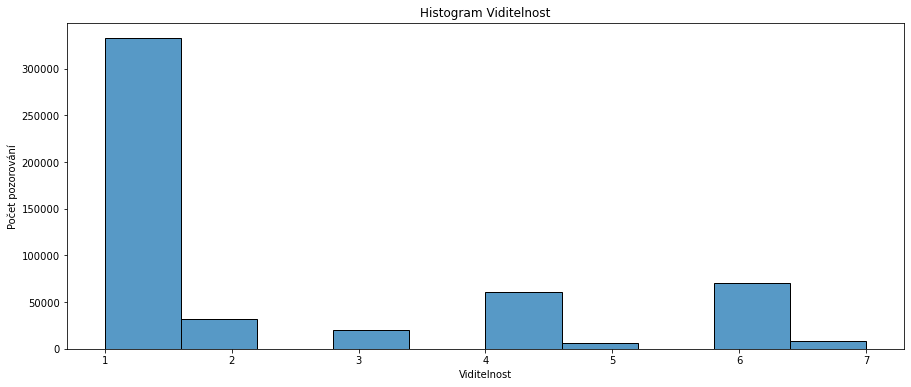

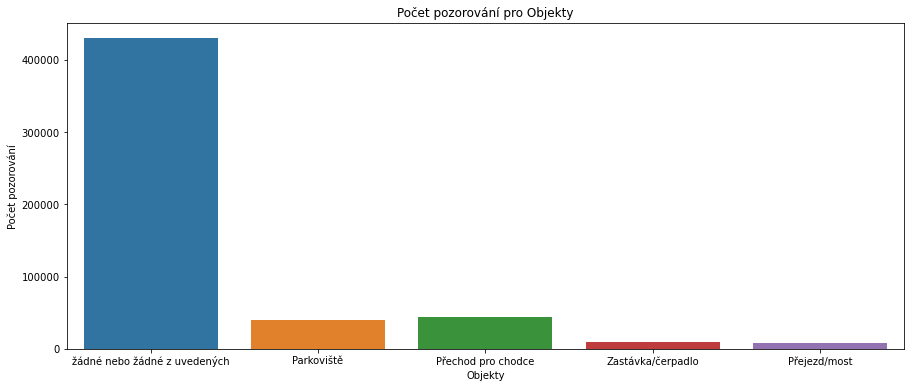

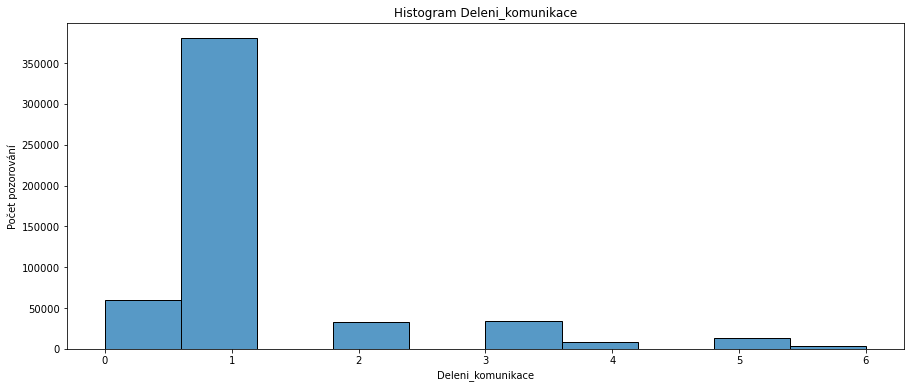

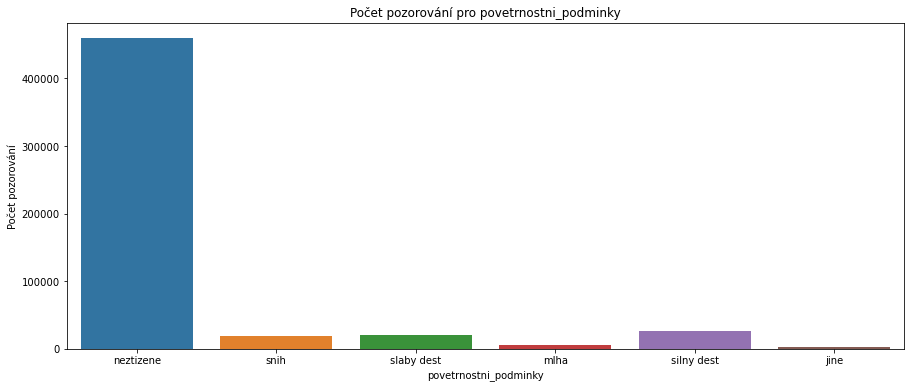

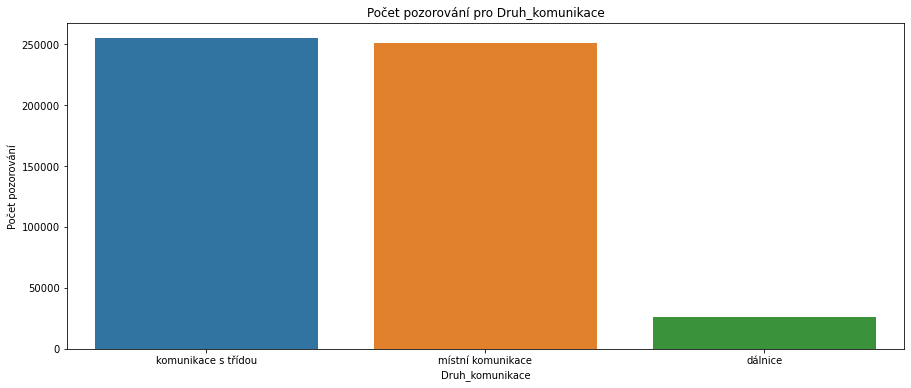

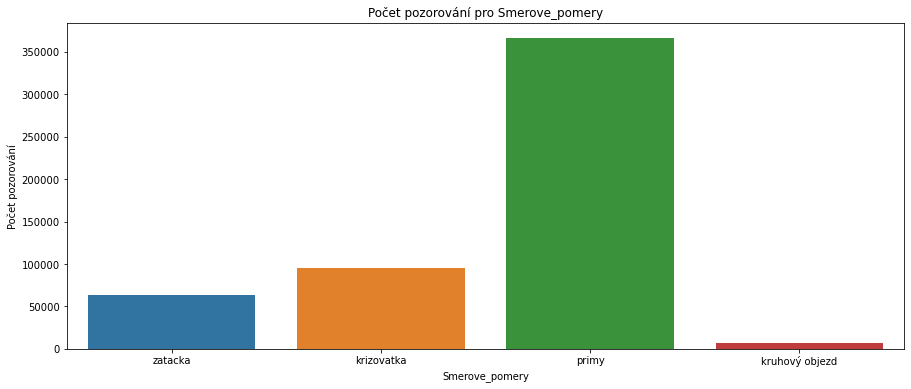

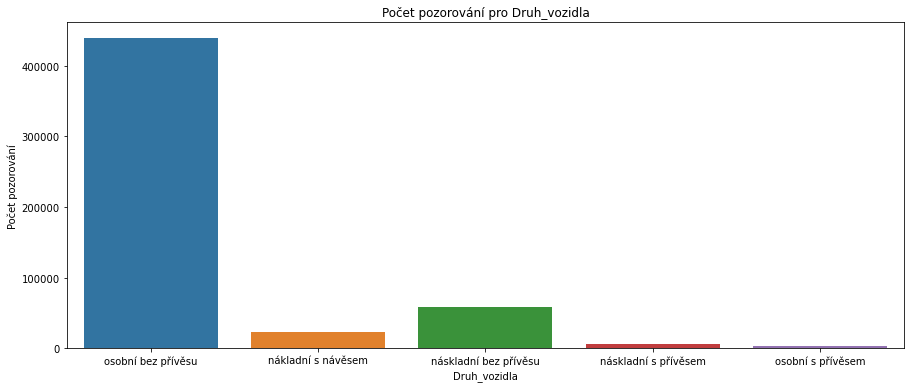

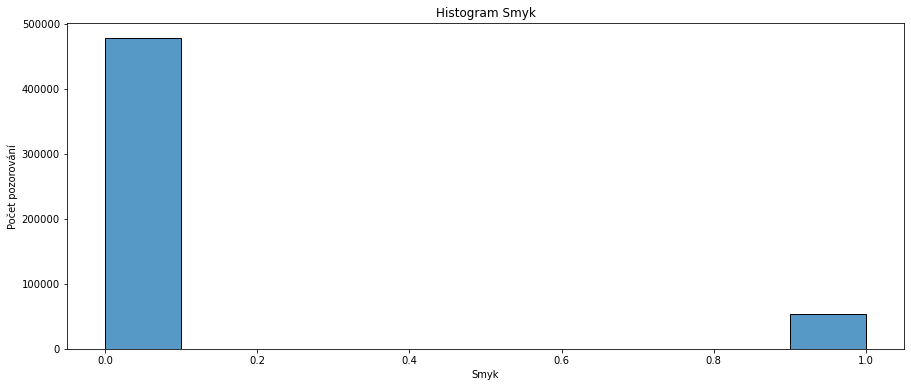

In [33]:
# loop přes všechny sloupce s daty

for column in df.columns:
    plt.figure(figsize=(15, 6))
    sns.color_palette("deep")
    if column not in ['Datum', 'ID','Cislo_komunikace','Znacka','Rok_vyroby']:
        # vykreslení histogramu pro numerické proměnné
        if df[column].dtype == "int64" or data[column].dtype == "float64":
            sns.color_palette("deep")
            sns.histplot(data=df,x=column, bins=10)
            plt.xlabel(column)
            plt.ylabel("Počet pozorování")
            plt.title(f"Histogram {column}")
            plt.show()
        # vykreslení sloupcového grafu pro kategoriální proměnné
        else:
            sns.color_palette("deep")
            sns.countplot(data=df, x=column)
            plt.xlabel(column)
            plt.ylabel("Počet pozorování")
            plt.title(f"Počet pozorování pro {column}")
            plt.show()

### Occurencies for categories

In [34]:
import numpy as np
pd.set_option('display.max_rows', 500)
pivot_data = df.agg(['nunique']).T
pivot_data['over_8'] = np.where(pivot_data['nunique'] > 8, 1, 0).astype(int)

dict = {}
for x in df.columns:
    value_count = df[x].value_counts()
    value_count = value_count/df[x].count()
    dict[x] = value_count.where(lambda x : x < 0.05).count()
    
result = pd.merge(pivot_data, pd.Series(dict, name='under_5_perc'), left_index=True, right_index=True)
result['flag'] = np.where((result['over_8'] > 0) | (result['under_5_perc'] > 0), 1, 0)
display(result)

,nunique,over_8,under_5_perc,flag
Datum,2557,1,2557,1
Pocet_vozidel,16,1,14,1
region,14,1,8,1
target,4,0,2,1
Sucho_Mokro,3,0,1,1
Rizeni,4,0,2,1
Obdobi,4,0,0,0
Vikend,2,0,0,0
Obec,2,0,0,0
Prekrocena_rychlost,2,0,0,0


### Korelační matice

<AxesSubplot:>

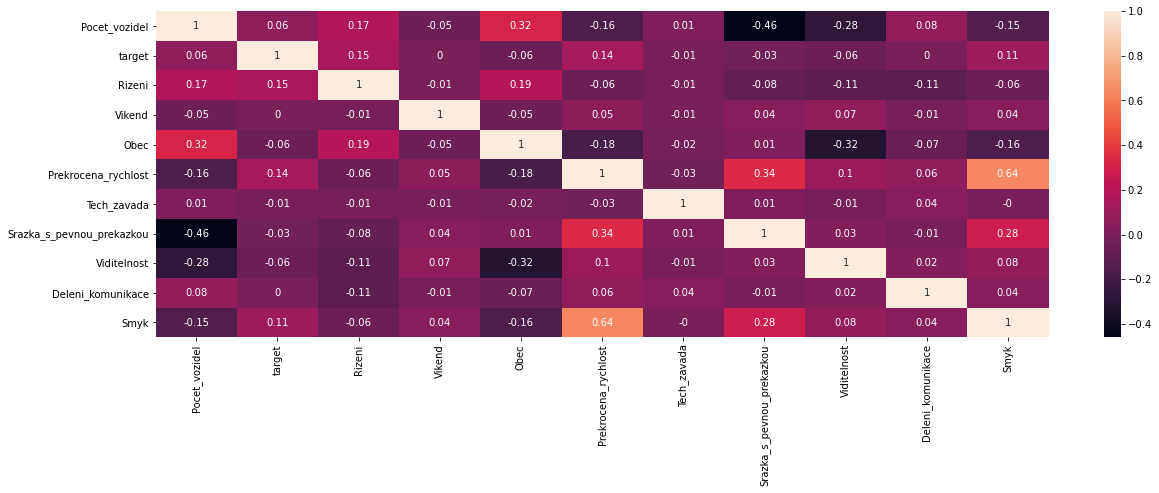

In [35]:
#korelačná matica
plt.figure(figsize=(20, 6))
cor_matrix = round(df.corr(),2)
sns.heatmap(cor_matrix, annot=True)

In [36]:
"""
pouze pro graf do prezentace
spustit na začátku, potřebuje všechna data
import datetime
data['Year'] = pd.to_datetime(data["p2a"]).dt.strftime('%Y')
temp = data.groupby('Year')['p13a'].sum()
sns.color_palette("deep")

plt.figure(figsize=(10,5))
sns.lineplot(data=temp, x=temp.index, y=temp.values)
plt.ylim(bottom=0)
plt.ylim(top=700)
plt.title("Vývoj počtu úmrtí při dopravních nehodách")

plt.savefig("vyvoj.jpeg")"""

'\npouze pro graf do prezentace\nspustit na začátku, potřebuje všechna data\nimport datetime\ndata[\'Year\'] = pd.to_datetime(data["p2a"]).dt.strftime(\'%Y\')\ntemp = data.groupby(\'Year\')[\'p13a\'].sum()\nsns.color_palette("deep")\n\nplt.figure(figsize=(10,5))\nsns.lineplot(data=temp, x=temp.index, y=temp.values)\nplt.ylim(bottom=0)\nplt.ylim(top=700)\nplt.title("Vývoj počtu úmrtí při dopravních nehodách")\n\nplt.savefig("vyvoj.jpeg")'

### Úprava proměnné počet vozidel

In [37]:
#odebrnání outliers
def removeOutliers(data, col):
    Q3 = np.nanquantile(data[col], 0.75)
    Q1 = np.nanquantile(data[col], 0.25)
    IQR = Q3 - Q1
      
    print("IQR value for column {c} is: {i}".format(c=col, i=IQR))
      
    lower_range = Q1 - 1.5 * IQR
    upper_range = Q3 + 1.5 * IQR
    
    if IQR != 0:
        data[col] = np.where(data[col] > upper_range, upper_range, data[col])
        data[col] = np.where(data[col] < lower_range, lower_range, data[col])   

iqr_data = pd.DataFrame(df["Pocet_vozidel"].copy())
iqr_data.index = df.index

for i in iqr_data.columns:
    removeOutliers(iqr_data, i)
  
display(iqr_data)
display(iqr_data.dtypes)

iqr_data.describe()

IQR value for column Pocet_vozidel is: 1.0


,Pocet_vozidel
ID,
190206200001,1.0
190206200002,1.0
190206200003,2.0
190206200004,1.0
190206200005,3.0
...,...
61306160594,2.0
61306160595,1.0
61306160597,2.0


Pocet_vozidel    float64
dtype: object

,Pocet_vozidel
count,531838.000000
mean,1.583753
std,0.609668
min,1.000000
25%,1.000000
50%,2.000000
75%,2.000000
max,3.500000


### One hot encoder

In [38]:
oh_data = df.loc[:, ~df.columns.isin(["Pocet_vozidel", 'Deleni_komunikace','Viditelnost',"Datum", "target"])].copy()
oh_data = pd.get_dummies(oh_data, columns=oh_data.columns.tolist(), prefix=oh_data.columns.tolist(), drop_first=True)

display(oh_data.head())
oh_data.shape


,region_Jihomoravsky,region_Karlovarsky,region_Kralovehradecky,region_Liberecky,region_Moravskoslezsky,region_Olomoucky,region_Pardobicky,region_Plzensky,region_Praha,region_Stredocesky,region_Ustecky,region_Vysocina,region_Zlinsky,Sucho_Mokro_Mokro,Sucho_Mokro_Sucho,Rizeni_2,Rizeni_3,Rizeni_4,Obdobi_leto,Obdobi_podzim,Obdobi_zima,Vikend_1,Obec_1,Prekrocena_rychlost_1,Tech_zavada_1,Srazka_s_pevnou_prekazkou_1,Smer_srazky_nepřichází v úvahu,Smer_srazky_z boku,Smer_srazky_zezadu,Smer_srazky_čelní,Staniceni_krizovatka,Staniceni_proti smeru,Staniceni_ve smeru,Druh_povrchu_dlažba,Druh_povrchu_jiný povrch,Druh_povrchu_panely,Druh_povrchu_štěrk,Druh_povrchu_živice,situovani_nehody_jízdní pruh,situovani_nehody_mimo komunikaci,Druh_nehody_jedouci_vozidlo,Druh_nehody_jine,Druh_nehody_odstavene_vozidlo,Druh_nehody_pevna_prekazka,Druh_nehody_zver,Stav_komunikace_jiný stav,Stav_komunikace_sklon 8%+,Stav_komunikace_výtluky,Stav_komunikace_změna vozovky/překážka,Objekty_Přechod pro chodce,Objekty_Přejezd/most,Objekty_Zastávka/čerpadlo,Objekty_žádné nebo žádné z uvedených,povetrnostni_podminky_mlha,povetrnostni_podminky_neztizene,povetrnostni_podminky_silny dest,povetrnostni_podminky_slaby dest,povetrnostni_podminky_snih,Druh_komunikace_komunikace s třídou,Druh_komunikace_místní komunikace,Smerove_pomery_kruhový objezd,Smerove_pomery_primy,Smerove_pomery_zatacka,Druh_vozidla_náskladní bez přívěsu,Druh_vozidla_náskladní s přívěsem,Druh_vozidla_osobní bez přívěsu,Druh_vozidla_osobní s přívěsem,Smyk_1.0
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
190206200001,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0
190206200002,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,1,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1
190206200003,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0
190206200004,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1
190206200005,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1


(531838, 68)

In [39]:
#Spojenie datasetu s ordinalnymi a numerickymi premennymi
full_data = pd.merge(oh_data, iqr_data, how='inner', left_index=True, right_index=True) 
full_data = pd.merge(full_data, df[['target']], how='inner', left_index=True, right_index=True)
full_data = pd.merge(full_data, df[['Datum']], how='inner', left_index=True, right_index=True)
full_data = pd.merge(full_data, df[['Deleni_komunikace']], how='inner', left_index=True, right_index=True)
full_data = pd.merge(full_data, df[['Viditelnost']], how='inner', left_index=True, right_index=True)
df=full_data
display(full_data)

,region_Jihomoravsky,region_Karlovarsky,region_Kralovehradecky,region_Liberecky,region_Moravskoslezsky,region_Olomoucky,region_Pardobicky,region_Plzensky,region_Praha,region_Stredocesky,region_Ustecky,region_Vysocina,region_Zlinsky,Sucho_Mokro_Mokro,Sucho_Mokro_Sucho,Rizeni_2,Rizeni_3,Rizeni_4,Obdobi_leto,Obdobi_podzim,Obdobi_zima,Vikend_1,Obec_1,Prekrocena_rychlost_1,Tech_zavada_1,Srazka_s_pevnou_prekazkou_1,Smer_srazky_nepřichází v úvahu,Smer_srazky_z boku,Smer_srazky_zezadu,Smer_srazky_čelní,Staniceni_krizovatka,Staniceni_proti smeru,Staniceni_ve smeru,Druh_povrchu_dlažba,Druh_povrchu_jiný povrch,Druh_povrchu_panely,Druh_povrchu_štěrk,Druh_povrchu_živice,situovani_nehody_jízdní pruh,situovani_nehody_mimo komunikaci,Druh_nehody_jedouci_vozidlo,Druh_nehody_jine,Druh_nehody_odstavene_vozidlo,Druh_nehody_pevna_prekazka,Druh_nehody_zver,Stav_komunikace_jiný stav,Stav_komunikace_sklon 8%+,Stav_komunikace_výtluky,Stav_komunikace_změna vozovky/překážka,Objekty_Přechod pro chodce,Objekty_Přejezd/most,Objekty_Zastávka/čerpadlo,Objekty_žádné nebo žádné z uvedených,povetrnostni_podminky_mlha,povetrnostni_podminky_neztizene,povetrnostni_podminky_silny dest,povetrnostni_podminky_slaby dest,povetrnostni_podminky_snih,Druh_komunikace_komunikace s třídou,Druh_komunikace_místní komunikace,Smerove_pomery_kruhový objezd,Smerove_pomery_primy,Smerove_pomery_zatacka,Druh_vozidla_náskladní bez přívěsu,Druh_vozidla_náskladní s přívěsem,Druh_vozidla_osobní bez přívěsu,Druh_vozidla_osobní s přívěsem,Smyk_1.0,Pocet_vozidel,target,Datum,Deleni_komunikace,Viditelnost
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
28224655,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,2.0,0,2022-07-18,5,1.0
29220778,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,2.0,0,2022-08-09,1,1.0
29222305,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,2.0,0,2022-08-27,0,1.0
29222369,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,2.0,0,2022-06-10,5,1.0
29224717,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,1.0,0,2022-09-09,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190910224043,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,2.0,0,2022-12-27,0,6.0
190910224060,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1.0,0,2022-12-28,1,6.0
190910224288,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1.0,0,2022-12-30,1,1.0


In [40]:
#Rozdělení dat na validační část a část, na které budeme trenovat a testovat náš model.
from datetime import datetime, timedelta

# Konverze sloupce Datum na typ datetime
df['Datum'] = pd.to_datetime(df['Datum'])

# Určení datumu pro filtrování
last_date = df['Datum'].max()
two_months_ago = last_date - timedelta(days=60)

# Rozdělení datasetu na validate_df a train_test_df
validate_df = df[df['Datum'] >= two_months_ago]
train_test_df = df[df['Datum'] < two_months_ago]

# Výpis výsledků
print("validate_df:")
print(validate_df)
print("\ntrain_test_df:")
print(train_test_df)

validate_df:
              region_Jihomoravsky  region_Karlovarsky  region_Kralovehradecky  \
ID                                                                              
35222389                        0                   0                       0   
35222488                        0                   0                       0   
35222584                        0                   0                       0   
35223040                        0                   0                       0   
35223101                        0                   0                       0   
...                           ...                 ...                     ...   
190910224043                    0                   1                       0   
190910224060                    0                   1                       0   
190910224288                    0                   1                       0   
190910224334                    0                   1                       0   
190910224416   

In [41]:
#Vymazanie stlpca Datum
validate_df=validate_df.drop('Datum',axis=1)
train_test_df=train_test_df.drop('Datum',axis=1)

## Dataset balancing: undersampling of majority class + SMOTE oversampling of minority classes

In [42]:
train_test_df_undersample0 = train_test_df[train_test_df.target==0].sample(n=20000, random_state=42).copy()
train_test_df_undersample1 = train_test_df[train_test_df.target==1].sample(n=20000, random_state=42).copy()


In [43]:
train_test_df_undersample0.target.value_counts()

0    20000
Name: target, dtype: int64

In [44]:
train_test_df_minority = train_test_df[~train_test_df.target.isin([0,1])].copy()

In [45]:
train_test_df_sample = pd.concat([train_test_df_undersample0, train_test_df_undersample1, train_test_df_minority])

In [46]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
train_test_df_sample, _ = oversample.fit_resample(train_test_df_sample, train_test_df_sample.target)

In [47]:
train_test_df_sample.target.value_counts()

0    20000
1    20000
2    20000
3    20000
Name: target, dtype: int64

## Chi-Square Statistic

### Feature selection based on Chi-square

#### Selection of categorical features

In [48]:
chi_data=train_test_df_sample
unique_count_ratio = 0.05
empty_ratio = 0.9
min_distinct_values = 2
excluded_features = ['target','Pocet_vozidel']
cat_features = []
columns = chi_data.columns 
#consider feature categorical if ratio is below given value and number of unique records is >= 2
for var in columns:
    if \
      1.*chi_data[var].nunique()/chi_data[var].count() < unique_count_ratio \
      and chi_data[var].nunique() >= min_distinct_values \
      and chi_data[var].isna().sum() / chi_data[var].count() < empty_ratio:
        cat_features.append(var)
cat_features = [f for f in cat_features if f not in excluded_features ]
display(cat_features)

['region_Jihomoravsky',
 'region_Karlovarsky',
 'region_Kralovehradecky',
 'region_Liberecky',
 'region_Moravskoslezsky',
 'region_Olomoucky',
 'region_Pardobicky',
 'region_Plzensky',
 'region_Praha',
 'region_Stredocesky',
 'region_Ustecky',
 'region_Vysocina',
 'region_Zlinsky',
 'Sucho_Mokro_Mokro',
 'Sucho_Mokro_Sucho',
 'Rizeni_2',
 'Rizeni_3',
 'Rizeni_4',
 'Obdobi_leto',
 'Obdobi_podzim',
 'Obdobi_zima',
 'Vikend_1',
 'Obec_1',
 'Prekrocena_rychlost_1',
 'Tech_zavada_1',
 'Srazka_s_pevnou_prekazkou_1',
 'Smer_srazky_nepřichází v úvahu',
 'Smer_srazky_z boku',
 'Smer_srazky_zezadu',
 'Smer_srazky_čelní',
 'Staniceni_krizovatka',
 'Staniceni_proti smeru',
 'Staniceni_ve smeru',
 'Druh_povrchu_dlažba',
 'Druh_povrchu_jiný povrch',
 'Druh_povrchu_panely',
 'Druh_povrchu_štěrk',
 'Druh_povrchu_živice',
 'situovani_nehody_jízdní pruh',
 'situovani_nehody_mimo komunikaci',
 'Druh_nehody_jedouci_vozidlo',
 'Druh_nehody_jine',
 'Druh_nehody_odstavene_vozidlo',
 'Druh_nehody_pevna_prekaz

#### Chi-square computation

In [49]:
from sklearn.feature_selection import chi2
chi = chi2(df[cat_features], df.target)
chi_table = pd.DataFrame()
chi_table['chi_sq_value'] = chi[0]
chi_table['p_value'] = chi[1]
chi_table['feature'] = cat_features

display(chi_table.set_index('feature').sort_values('p_value', ascending=True))

,chi_sq_value,p_value
feature,,
region_Jihomoravsky,4325.719893,0.000000e+00
Smer_srazky_z boku,3479.358380,0.000000e+00
Smer_srazky_čelní,21441.034504,0.000000e+00
Staniceni_krizovatka,14178.270801,0.000000e+00
Druh_povrchu_dlažba,2209.806455,0.000000e+00
situovani_nehody_mimo komunikaci,3013.103283,0.000000e+00
Druh_nehody_jedouci_vozidlo,8431.315948,0.000000e+00
Druh_nehody_jine,37479.779731,0.000000e+00
Druh_nehody_odstavene_vozidlo,11863.331652,0.000000e+00


In [50]:
significant_columns = chi_table[chi_table['p_value']<0.05].sort_values('p_value', ascending=True)
significant_columns

,chi_sq_value,p_value,feature
0,4325.719893,0.000000e+00,region_Jihomoravsky
27,3479.358380,0.000000e+00,Smer_srazky_z boku
29,21441.034504,0.000000e+00,Smer_srazky_čelní
30,14178.270801,0.000000e+00,Staniceni_krizovatka
33,2209.806455,0.000000e+00,Druh_povrchu_dlažba
39,3013.103283,0.000000e+00,situovani_nehody_mimo komunikaci
40,8431.315948,0.000000e+00,Druh_nehody_jedouci_vozidlo
41,37479.779731,0.000000e+00,Druh_nehody_jine
42,11863.331652,0.000000e+00,Druh_nehody_odstavene_vozidlo
44,22049.732119,0.000000e+00,Druh_nehody_zver


In [51]:
columns_to_keep = list(significant_columns['feature'])

In [52]:
columns_to_keep.append('target')
columns_to_keep.append('Pocet_vozidel')

In [53]:
columns_to_keep

['region_Jihomoravsky',
 'Smer_srazky_z boku',
 'Smer_srazky_čelní',
 'Staniceni_krizovatka',
 'Druh_povrchu_dlažba',
 'situovani_nehody_mimo komunikaci',
 'Druh_nehody_jedouci_vozidlo',
 'Druh_nehody_jine',
 'Druh_nehody_odstavene_vozidlo',
 'Druh_nehody_zver',
 'Objekty_Přechod pro chodce',
 'Druh_komunikace_komunikace s třídou',
 'Druh_komunikace_místní komunikace',
 'Smerove_pomery_primy',
 'Smerove_pomery_zatacka',
 'Smyk_1.0',
 'Smer_srazky_nepřichází v úvahu',
 'Prekrocena_rychlost_1',
 'Viditelnost',
 'region_Plzensky',
 'region_Praha',
 'Rizeni_2',
 'region_Ustecky',
 'Rizeni_3',
 'Smer_srazky_zezadu',
 'Druh_vozidla_náskladní bez přívěsu',
 'Obec_1',
 'region_Pardobicky',
 'Sucho_Mokro_Mokro',
 'Druh_nehody_pevna_prekazka',
 'Srazka_s_pevnou_prekazkou_1',
 'Druh_vozidla_osobní bez přívěsu',
 'Staniceni_proti smeru',
 'povetrnostni_podminky_slaby dest',
 'povetrnostni_podminky_silny dest',
 'Rizeni_4',
 'Obdobi_leto',
 'region_Zlinsky',
 'Druh_vozidla_náskladní s přívěsem',
 '

In [54]:
train_test_df_sample=train_test_df_sample[columns_to_keep]
train_test_df_sample

,region_Jihomoravsky,Smer_srazky_z boku,Smer_srazky_čelní,Staniceni_krizovatka,Druh_povrchu_dlažba,situovani_nehody_mimo komunikaci,Druh_nehody_jedouci_vozidlo,Druh_nehody_jine,Druh_nehody_odstavene_vozidlo,Druh_nehody_zver,Objekty_Přechod pro chodce,Druh_komunikace_komunikace s třídou,Druh_komunikace_místní komunikace,Smerove_pomery_primy,Smerove_pomery_zatacka,Smyk_1.0,Smer_srazky_nepřichází v úvahu,Prekrocena_rychlost_1,Viditelnost,region_Plzensky,region_Praha,Rizeni_2,region_Ustecky,Rizeni_3,Smer_srazky_zezadu,Druh_vozidla_náskladní bez přívěsu,Obec_1,region_Pardobicky,Sucho_Mokro_Mokro,Druh_nehody_pevna_prekazka,Srazka_s_pevnou_prekazkou_1,Druh_vozidla_osobní bez přívěsu,Staniceni_proti smeru,povetrnostni_podminky_slaby dest,povetrnostni_podminky_silny dest,Rizeni_4,Obdobi_leto,region_Zlinsky,Druh_vozidla_náskladní s přívěsem,povetrnostni_podminky_snih,Druh_povrchu_štěrk,Druh_povrchu_živice,Sucho_Mokro_Sucho,region_Vysocina,Objekty_žádné nebo žádné z uvedených,Objekty_Přejezd/most,povetrnostni_podminky_neztizene,Druh_povrchu_jiný povrch,Smerove_pomery_kruhový objezd,Stav_komunikace_výtluky,region_Moravskoslezsky,Obdobi_zima,region_Stredocesky,Staniceni_ve smeru,Tech_zavada_1,Druh_povrchu_panely,region_Liberecky,region_Olomoucky,povetrnostni_podminky_mlha,region_Kralovehradecky,region_Karlovarsky,Objekty_Zastávka/čerpadlo,situovani_nehody_jízdní pruh,Stav_komunikace_změna vozovky/překážka,Deleni_komunikace,Stav_komunikace_jiný stav,Vikend_1,Obdobi_podzim,Stav_komunikace_sklon 8%+,target,Pocet_vozidel
0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1.0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2.0
1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1.0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,2.0
2,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,4.0,0,0,1,0,0,0,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1.0
3,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,1,0,6.0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,2.0
4,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,6.0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,3,1.0
79996,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,1,1.0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,3,1.0
79997,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,1,0,1,1.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,3,2.0
79998,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,1,1.0,0,0,0,0,0,0,0,1,0,0,1,1,1,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,3,1.0


## Train test split

In [55]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_test_df_sample, train_test_df_sample.target, test_size=0.20, random_state=42)
X_train=X_train.drop('target',axis=1)
X_test=X_test.drop('target',axis=1)
print('Frequencies of target variable in training data set:',y_train.value_counts())
print('Frequencies of target variable in testing data set:',y_test.value_counts())

Frequencies of target variable in training data set: 0    16094
3    16009
2    15970
1    15927
Name: target, dtype: int64
Frequencies of target variable in testing data set: 1    4073
2    4030
3    3991
0    3906
Name: target, dtype: int64


## Models training

#### Logistická regresia

In [56]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,mean_squared_error
from sklearn.metrics import make_scorer,classification_report, f1_score,precision_score,recall_score


log_model = LogisticRegression(class_weight="balanced")
log_model.fit(X_train, y_train)
y_pred=log_model.predict(X_test)


print(classification_report(y_pred, y_test))
print('\nAccuracy Score for Logistic regression model: ', accuracy_score(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.72      0.72      0.72      3922
           1       0.57      0.52      0.55      4473
           2       0.36      0.47      0.41      3072
           3       0.71      0.63      0.67      4533

    accuracy                           0.59     16000
   macro avg       0.59      0.59      0.59     16000
weighted avg       0.61      0.59      0.60     16000


Accuracy Score for Logistic regression model:  0.5905625


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


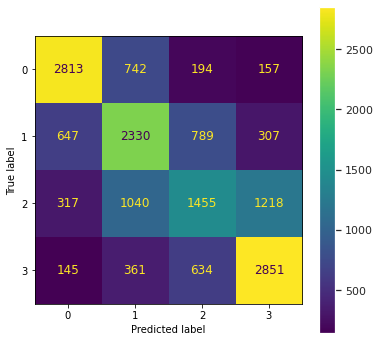

In [57]:
confusion_matrix = metrics.confusion_matrix(y_test,y_pred)
#confusion_matrix = metrics.confusion_matrix(y_valid,y_pred_val)
fig, _ = plt.subplots(nrows=1, figsize=(6,6))
ax = plt.subplot(1, 1, 1)
ax.grid(False)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
sns.set (rc = {'figure.figsize':(10, 10)})
_ = cm_display.plot(ax=ax)

#### Random Forest

In [58]:
from sklearn.ensemble import RandomForestClassifier 

for x in range(2,10):
    for y in [100,70,50,30,20,10]:
        forest=RandomForestClassifier(max_depth=x,n_estimators=y)
        forest.fit(X_train,y_train)
        y_pred=forest.predict(X_test)
        print("depth= ",x,' estimators= ',y,' accuracy= ',accuracy_score(y_test,y_pred))

depth=  2  estimators=  100  accuracy=  0.4865
depth=  2  estimators=  70  accuracy=  0.4693125
depth=  2  estimators=  50  accuracy=  0.4835625
depth=  2  estimators=  30  accuracy=  0.4904375
depth=  2  estimators=  20  accuracy=  0.4874375
depth=  2  estimators=  10  accuracy=  0.4583125
depth=  3  estimators=  100  accuracy=  0.4978125
depth=  3  estimators=  70  accuracy=  0.498375
depth=  3  estimators=  50  accuracy=  0.50175
depth=  3  estimators=  30  accuracy=  0.4935
depth=  3  estimators=  20  accuracy=  0.4959375
depth=  3  estimators=  10  accuracy=  0.472375
depth=  4  estimators=  100  accuracy=  0.4994375
depth=  4  estimators=  70  accuracy=  0.508875
depth=  4  estimators=  50  accuracy=  0.5074375
depth=  4  estimators=  30  accuracy=  0.5059375
depth=  4  estimators=  20  accuracy=  0.51225
depth=  4  estimators=  10  accuracy=  0.49725
depth=  5  estimators=  100  accuracy=  0.5109375
depth=  5  estimators=  70  accuracy=  0.50575
depth=  5  estimators=  50  accur

In [59]:
forest_model=RandomForestClassifier(max_depth=9,n_estimators=50)
forest_model.fit(X_train,y_train)

y_pred=forest_model.predict(X_test)
print(classification_report(y_pred, y_test))
print('\nAccuracy Score for Random Forest model: ', accuracy_score(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.71      0.70      0.71      3931
           1       0.43      0.50      0.46      3468
           2       0.32      0.51      0.40      2554
           3       0.77      0.51      0.62      6047

    accuracy                           0.56     16000
   macro avg       0.56      0.56      0.55     16000
weighted avg       0.61      0.56      0.57     16000


Accuracy Score for Random Forest model:  0.557125


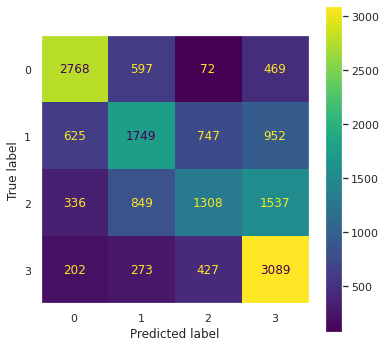

In [60]:
confusion_matrix = metrics.confusion_matrix(y_test,y_pred)

fig, _ = plt.subplots(nrows=1, figsize=(6,6))
ax = plt.subplot(1, 1, 1)
ax.grid(False)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
sns.set (rc = {'figure.figsize':(10, 10)})
_ = cm_display.plot(ax=ax)

In [61]:
# Top 15 features
features_top_15 = pd.DataFrame(zip(forest_model.feature_importances_, list(X_train.columns))  
                              ).sort_values(by=0, ascending=False)[:15]
features_top_15.reset_index()

,index,0,1
0,9,0.177020,Druh_nehody_zver
1,26,0.100384,Obec_1
2,7,0.075460,Druh_nehody_jine
3,8,0.058372,Druh_nehody_odstavene_vozidlo
4,12,0.049591,Druh_komunikace_místní komunikace
5,69,0.042916,Pocet_vozidel
6,2,0.038004,Smer_srazky_čelní
7,20,0.037173,region_Praha
8,24,0.030378,Smer_srazky_zezadu
9,11,0.028754,Druh_komunikace_komunikace s třídou


#### Decision Tree

In [187]:
from sklearn.tree import DecisionTreeClassifier
tree_model = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=20,
            min_impurity_decrease=0.0, 
            min_samples_leaf=1, min_samples_split=20,
            min_weight_fraction_leaf=0.0, random_state=None,
            splitter='best')
tree_model.fit(X_train, y_train)

y_pred=tree_model.predict(X_test)
print(classification_report(y_pred, y_test))
print('\nAccuracy Score for Decision Tree model: ', accuracy_score(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.75      0.73      0.74      4067
           1       0.75      0.54      0.63      5567
           2       0.12      0.35      0.18       652
           3       0.00      0.00      0.00         0

    accuracy                           0.60     10286
   macro avg       0.41      0.40      0.39     10286
weighted avg       0.71      0.60      0.64     10286


Accuracy Score for Decision Tree model:  0.6035387905891503


/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


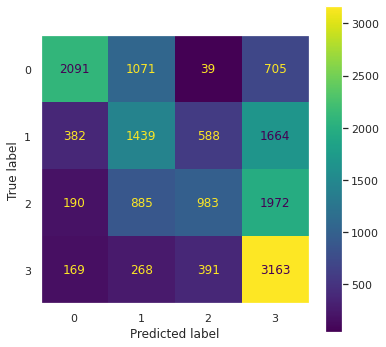

In [109]:
confusion_matrix = metrics.confusion_matrix(y_test,y_pred)

fig, _ = plt.subplots(nrows=1, figsize=(6,6))
ax = plt.subplot(1, 1, 1)
ax.grid(False)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
sns.set (rc = {'figure.figsize':(10, 10)})
_ = cm_display.plot(ax=ax)

In [189]:
# Top 15 features
features_top_15 = pd.DataFrame(zip(tree_model.feature_importances_, list(X_train.columns))  
                              ).sort_values(by=0, ascending=False)[:15]
features_top_15.reset_index()

,index,0,1
0,9,0.317081,Druh_nehody_zver
1,8,0.185640,Druh_nehody_odstavene_vozidlo
2,20,0.112416,region_Praha
3,7,0.090458,Druh_nehody_jine
4,29,0.070114,Druh_nehody_pevna_prekazka
5,11,0.058469,Druh_komunikace_komunikace s třídou
6,26,0.045851,Obec_1
7,2,0.035251,Smer_srazky_čelní
8,22,0.023944,region_Ustecky
9,12,0.021125,Druh_komunikace_místní komunikace


#### Neural Network

In [190]:
from sklearn.neural_network import MLPClassifier

nn_model = MLPClassifier(hidden_layer_sizes=(64, 64))

nn_model.fit(X_train, y_train)
y_pred=nn_model.predict(X_test)
print(classification_report(y_pred, y_test))
print('\nAccuracy Score for NN model: ', accuracy_score(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.75      0.72      0.74      4121
           1       0.62      0.56      0.59      4458
           2       0.31      0.38      0.34      1466
           3       0.11      0.22      0.14       241

    accuracy                           0.59     10286
   macro avg       0.45      0.47      0.45     10286
weighted avg       0.62      0.59      0.60     10286


Accuracy Score for NN model:  0.5917752284658759


/opt/conda/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


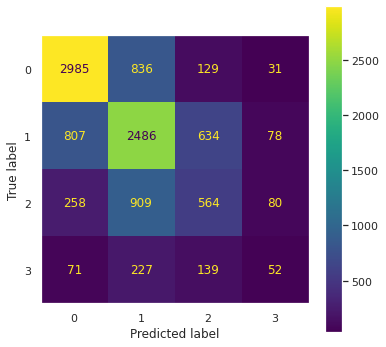

In [191]:
confusion_matrix = metrics.confusion_matrix(y_test,y_pred)

fig, _ = plt.subplots(nrows=1, figsize=(6,6))
ax = plt.subplot(1, 1, 1)
ax.grid(False)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
sns.set (rc = {'figure.figsize':(10, 10)})
_ = cm_display.plot(ax=ax)

#### ADA Boosts

In [192]:
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier

ada_model = AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=5, max_features=10, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, random_state=42,
            splitter='best'),
          learning_rate=0.75, n_estimators=300, random_state=42)
ada_model.fit(X_train,y_train)
y_pred=ada_model.predict(X_test)

In [193]:
print(classification_report(y_pred, y_test))
print('\nAccuracy Score for ADA Boost model: ', accuracy_score(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.64      0.77      0.70      3319
           1       0.43      0.55      0.48      3126
           2       0.39      0.34      0.36      2096
           3       0.45      0.13      0.20      1745

    accuracy                           0.51     10286
   macro avg       0.48      0.45      0.44     10286
weighted avg       0.49      0.51      0.48     10286


Accuracy Score for ADA Boost model:  0.5058331713007972


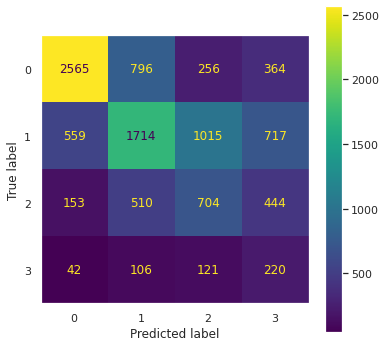

In [194]:
confusion_matrix = metrics.confusion_matrix(y_test,y_pred)

fig, _ = plt.subplots(nrows=1, figsize=(6,6))
ax = plt.subplot(1, 1, 1)
ax.grid(False)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
sns.set (rc = {'figure.figsize':(10, 10)})
_ = cm_display.plot(ax=ax)

### Provedení modelů na validačních datech

#### Logistická regrese

In [97]:
# Rozdělení validačních dat na target (y_valid) a zbytek (X_valid)
y_valid = validate_df['target']
X_valid = validate_df.drop(['target', 'Druh_vozidla_osobní s přívěsem'], axis=1) #proměnnou "Druh_vozidla_osobní s přívěsem" vyřadíme po chisq testu jako nepodstatnou.
X_valid = X_valid[X_train.columns]


log_model = LogisticRegression(class_weight="balanced")
log_model.fit(X_train, y_train)
y_pred_val=log_model.predict(X_valid) 
#y_valid = target

print(classification_report(y_pred_val, y_valid))
print('\nAccuracy Score for Logistic regression model after validation: ', accuracy_score(y_pred_val,y_valid))

              precision    recall  f1-score   support

           0       0.75      0.94      0.83      7380
           1       0.61      0.40      0.48      3270
           2       0.29      0.07      0.11       573
           3       0.23      0.03      0.06       377

    accuracy                           0.71     11600
   macro avg       0.47      0.36      0.37     11600
weighted avg       0.67      0.71      0.67     11600


Accuracy Score for Logistic regression model after validation:  0.7135344827586206


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


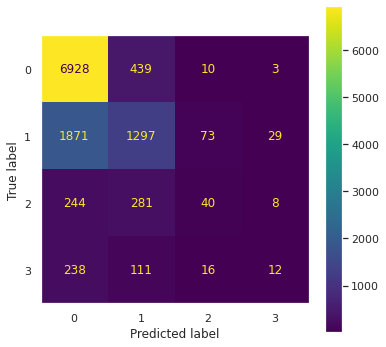

In [98]:
confusion_matrix = metrics.confusion_matrix(y_pred_val,y_valid)
#confusion_matrix = metrics.confusion_matrix(y_valid,y_pred_val)
fig, _ = plt.subplots(nrows=1, figsize=(6,6))
ax = plt.subplot(1, 1, 1)
ax.grid(False)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
sns.set (rc = {'figure.figsize':(10, 10)})
_ = cm_display.plot(ax=ax)

#### Random Forest

In [110]:
from sklearn.ensemble import RandomForestClassifier 

for x in range(2,10):
    for y in [100,70,50,30,20,10]:
        forest=RandomForestClassifier(max_depth=x,n_estimators=y)
        forest.fit(X_train,y_train)
        y_pred_val=forest.predict(X_valid)
        print("depth= ",x,' estimators= ',y,' accuracy= ',accuracy_score(y_pred_val, y_valid))

depth=  2  estimators=  100  accuracy=  0.579396551724138
depth=  2  estimators=  70  accuracy=  0.5782758620689655
depth=  2  estimators=  50  accuracy=  0.5905172413793104
depth=  2  estimators=  30  accuracy=  0.6262931034482758
depth=  2  estimators=  20  accuracy=  0.5720689655172414
depth=  2  estimators=  10  accuracy=  0.6012931034482759
depth=  3  estimators=  100  accuracy=  0.5827586206896552
depth=  3  estimators=  70  accuracy=  0.574396551724138
depth=  3  estimators=  50  accuracy=  0.579051724137931
depth=  3  estimators=  30  accuracy=  0.5712068965517242
depth=  3  estimators=  20  accuracy=  0.5896551724137931
depth=  3  estimators=  10  accuracy=  0.6069827586206896
depth=  4  estimators=  100  accuracy=  0.5968103448275862
depth=  4  estimators=  70  accuracy=  0.581551724137931
depth=  4  estimators=  50  accuracy=  0.5939655172413794
depth=  4  estimators=  30  accuracy=  0.5731896551724138
depth=  4  estimators=  20  accuracy=  0.6036206896551725
depth=  4  esti

In [111]:
forest_model=RandomForestClassifier(max_depth=9,n_estimators=50)
forest_model.fit(X_train,y_train)

y_pred_val=forest_model.predict(X_valid)
print(classification_report(y_pred_val, y_valid))
print('\nAccuracy Score for Random Forest model after validation: ', accuracy_score(y_pred_val, y_valid))

              precision    recall  f1-score   support

           0       0.69      0.95      0.80      6729
           1       0.44      0.35      0.39      2667
           2       0.38      0.09      0.14       622
           3       0.63      0.02      0.04      1582

    accuracy                           0.64     11600
   macro avg       0.54      0.35      0.34     11600
weighted avg       0.61      0.64      0.56     11600


Accuracy Score for Random Forest model after validation:  0.6380172413793104


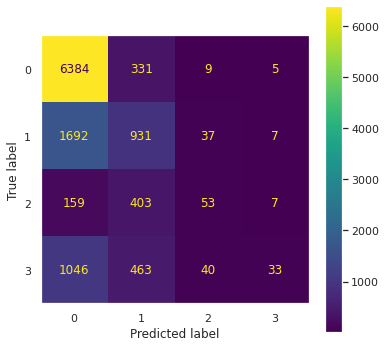

In [112]:
confusion_matrix = metrics.confusion_matrix(y_pred_val, y_valid)

fig, _ = plt.subplots(nrows=1, figsize=(6,6))
ax = plt.subplot(1, 1, 1)
ax.grid(False)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
sns.set (rc = {'figure.figsize':(10, 10)})
_ = cm_display.plot(ax=ax)

In [101]:
# Top 15 features
features_top_15 = pd.DataFrame(zip(tree_model.feature_importances_, list(X_train.columns))  
                              ).sort_values(by=0, ascending=False)[:15]
features_top_15.reset_index()

,index,0,1
0,9,0.263880,Druh_nehody_zver
1,26,0.209000,Obec_1
2,7,0.179789,Druh_nehody_jine
3,16,0.084802,Smer_srazky_nepřichází v úvahu
4,20,0.062289,region_Praha
5,2,0.037412,Smer_srazky_čelní
6,12,0.035303,Druh_komunikace_místní komunikace
7,24,0.031106,Smer_srazky_zezadu
8,18,0.025097,Viditelnost
9,31,0.015811,Druh_vozidla_osobní bez přívěsu


#### Decision Tree

In [106]:
from sklearn.tree import DecisionTreeClassifier
tree_model = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=20,
            min_impurity_decrease=0.0, 
            min_samples_leaf=1, min_samples_split=20,
            min_weight_fraction_leaf=0.0, random_state=None,
            splitter='best')
tree_model.fit(X_train, y_train)

y_pred_val=tree_model.predict(X_valid)
print(classification_report(y_pred_val, y_valid))
print('\nAccuracy Score for Decision Tree model after validation: ', accuracy_score(y_pred_val, y_valid))

              precision    recall  f1-score   support

           0       0.68      0.94      0.79      6658
           1       0.35      0.32      0.34      2338
           2       0.36      0.09      0.15       542
           3       0.67      0.02      0.03      2062

    accuracy                           0.61     11600
   macro avg       0.52      0.34      0.33     11600
weighted avg       0.60      0.61      0.53     11600


Accuracy Score for Decision Tree model:  0.613448275862069


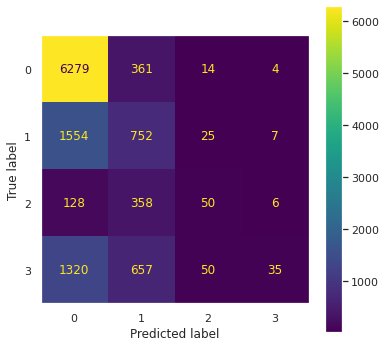

In [107]:
confusion_matrix = metrics.confusion_matrix(y_pred_val, y_valid)

fig, _ = plt.subplots(nrows=1, figsize=(6,6))
ax = plt.subplot(1, 1, 1)
ax.grid(False)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
sns.set (rc = {'figure.figsize':(10, 10)})
_ = cm_display.plot(ax=ax)

In [108]:
# Top 15 features
features_top_15 = pd.DataFrame(zip(tree_model.feature_importances_, list(X_train.columns))  
                              ).sort_values(by=0, ascending=False)[:15]
features_top_15.reset_index()

,index,0,1
0,9,0.263880,Druh_nehody_zver
1,26,0.209000,Obec_1
2,7,0.179789,Druh_nehody_jine
3,16,0.084802,Smer_srazky_nepřichází v úvahu
4,20,0.062289,region_Praha
5,2,0.037412,Smer_srazky_čelní
6,12,0.035303,Druh_komunikace_místní komunikace
7,24,0.031106,Smer_srazky_zezadu
8,18,0.025097,Viditelnost
9,31,0.015811,Druh_vozidla_osobní bez přívěsu


#### Neural Network

In [102]:
from sklearn.neural_network import MLPClassifier

nn_model = MLPClassifier(hidden_layer_sizes=(64, 64))

nn_model.fit(X_train, y_train)
y_pred_val=nn_model.predict(X_valid)
print(classification_report(y_pred_val, y_valid))
print('\nAccuracy Score for NN modelafter validation: ', accuracy_score(y_pred_val, y_valid))

              precision    recall  f1-score   support

           0       0.72      0.94      0.81      7097
           1       0.63      0.38      0.47      3508
           2       0.23      0.06      0.10       494
           3       0.17      0.02      0.03       501

    accuracy                           0.69     11600
   macro avg       0.44      0.35      0.36     11600
weighted avg       0.65      0.69      0.65     11600


Accuracy Score for NN model:  0.6928448275862069


/opt/conda/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


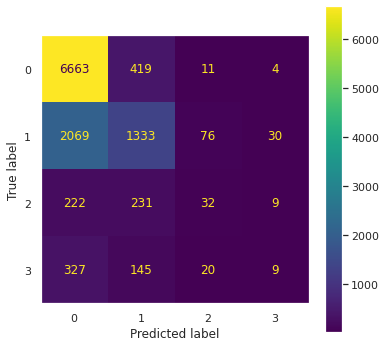

In [103]:
confusion_matrix = metrics.confusion_matrix(y_pred_val, y_valid)

fig, _ = plt.subplots(nrows=1, figsize=(6,6))
ax = plt.subplot(1, 1, 1)
ax.grid(False)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
sns.set (rc = {'figure.figsize':(10, 10)})
_ = cm_display.plot(ax=ax)

#### ADA Boosts

In [104]:
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier

ada_model = AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=5, max_features=10, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, random_state=42,
            splitter='best'),
          learning_rate=0.75, n_estimators=300, random_state=42)
ada_model.fit(X_train,y_train)
y_pred_val=ada_model.predict(X_valid)

print(classification_report(y_pred_val, y_valid))
print('\nAccuracy Score for ADA Boost model after validation: ', accuracy_score(y_pred_val, y_valid))

/opt/conda/lib/python3.8/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.76      0.94      0.84      7510
           1       0.54      0.38      0.45      3015
           2       0.35      0.06      0.11       757
           3       0.25      0.04      0.07       318

    accuracy                           0.71     11600
   macro avg       0.47      0.36      0.37     11600
weighted avg       0.66      0.71      0.67     11600


Accuracy Score for ADA Boost model:  0.7114655172413793


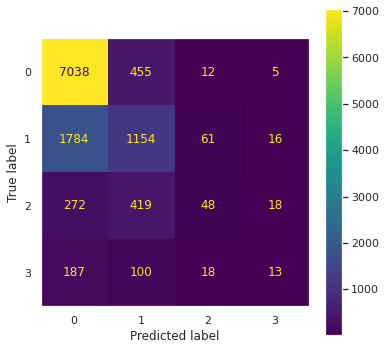

In [105]:
confusion_matrix = metrics.confusion_matrix(y_pred_val, y_valid)

fig, _ = plt.subplots(nrows=1, figsize=(6,6))
ax = plt.subplot(1, 1, 1)
ax.grid(False)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
sns.set (rc = {'figure.figsize':(10, 10)})
_ = cm_display.plot(ax=ax)

#### Decision Tree Excel

In [94]:
from sklearn.tree import DecisionTreeClassifier
tree_model = DecisionTreeClassifier( criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=200,
            min_impurity_decrease=0.0, 
            min_samples_leaf=1, min_samples_split=200,
            min_weight_fraction_leaf=0.0, random_state=None,
            splitter='best')
tree_model.fit(X_train, y_train)

y_pred=tree_model.predict(X_test)
print(classification_report(y_pred, y_test))
print('\nAccuracy Score for Decision Tree model: ', accuracy_score(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.54      0.74      0.62      2832
           1       0.35      0.39      0.37      3663
           2       0.24      0.49      0.33      2001
           3       0.79      0.42      0.55      7504

    accuracy                           0.48     16000
   macro avg       0.48      0.51      0.47     16000
weighted avg       0.58      0.48      0.49     16000


Accuracy Score for Decision Tree model:  0.47975


In [95]:
from sklearn import tree
import graphviz
 
dot_data = tree.export_graphviz(tree_model, out_file=None, 
                                feature_names=X_train.columns,  
                                class_names=y_train.unique().astype(str),  
                                filled=True, rounded=True,  
                                special_characters=True)

# Vytvorenie a zobrazenie grafu pomocou graphviz
graph = graphviz.Source(dot_data)
graph.view()

ModuleNotFoundError: No module named 'graphviz'